In [1]:
import gc
import os
import time
import datetime
from dateutil import relativedelta
from tqdm.notebook import tqdm
import numpy as np
import talib
from talib import MA_Type
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [2]:
def make_label(df, dropna=False):
    if dropna:
        df.dropna(inplace=True)
    
    df = df.sort_values(by=['symbol', 'Date'])
    
#     for lag in list(range(1, 3+1)):
#         df['tmp'] = df.groupby(['symbol'])['Close'].transform(lambda x: x.pct_change(periods=lag).shift(-lag))
        
#         df[f'label_next{lag}'] = (df['tmp'] >= 0.01).astype('int')
#         del df['tmp']

    df['Close_next10_max'] = df.groupby('symbol')['Close'].transform(lambda x: x.rolling(10).max().shift(-10))
    df['label_next10_max'] = (df['Close_next10_max'] / df['Close'] - 1 >= 0.01).astype('int')

#     df['Close_next3to10_max'] = df.groupby('symbol')['Close'].transform(lambda x: x.rolling(7).max().shift(-9))
#     df['label_next3to10_max'] = (df['Close_next3to10_max'] / df['Close'] - 1 >= 0.01).astype('int')
        
    return df

def make_pct_change(df):
    df = df.sort_values(by=['symbol', 'Date'])
    
    for lag_day in list(range(1, 16)) + [20, 30, 40]:
        df[f'pct_change_price_lag{lag_day}'] = df.groupby(['symbol'])['Close'].transform(lambda x: x.pct_change(periods=lag_day))
        
    return df
    
def make_ext_features(df):
    df = df.sort_values(by=['symbol', 'Date'])
    
    df['ext_feat_OpenClose'] = df['Close'] / df['Open'] - 1
    df['ext_feat_upOrDownInDay'] = (df['ext_feat_OpenClose'] > 0).astype('int')
    
    df['ext_feat_OpenHigh'] = df['High'] / df['Open'] - 1
    df['ext_feat_OpenLow'] = df['Low'] / df['Open'] - 1
    
    df['ext_feat_CloseHigh'] = df['High'] / df['Close'] - 1
    df['ext_feat_CloseLow'] = df['Low'] / df['Close'] - 1
    
    df['ext_feat_HighLow'] = df['High'] / df['Low'] - 1
    
    for lag_day in [5, 10, 20, 30]:
        df['ext_feat_countUpDays'] = df.groupby(['symbol'])['ext_feat_upOrDownInDay'].transform(lambda x: x.rolling(lag_day).sum())

    return df
    
    
def make_technical_features(df, dropna=False):
    if dropna:
        df.dropna(inplace=True)
        
    df = df.sort_values(by=['symbol', 'Date'])
    
    for timeperiod in [20, 50]:
        df[f'ta_SMA{timeperiod}'] = df.groupby('symbol')['Close'].transform(lambda x: talib.SMA(x, timeperiod=timeperiod)) 

    for timeperiod in [20, 50]:
        df[f'ta_EMA{timeperiod}'] = df.groupby('symbol')['Close'].transform(lambda x: talib.EMA(x, timeperiod=timeperiod)) 
    
    df['ta_BBANDS_upper'] = df.groupby('symbol')['Close'].transform(lambda x: talib.BBANDS(x, timeperiod=5, matype=MA_Type.T3)[0])
    df['ta_BBANDS_middle'] = df.groupby('symbol')['Close'].transform(lambda x: talib.BBANDS(x, timeperiod=5, matype=MA_Type.T3)[1])
    df['ta_BBANDS_lower'] = df.groupby('symbol')['Close'].transform(lambda x: talib.BBANDS(x, timeperiod=5, matype=MA_Type.T3)[2])
    
#     df['ta_MACD_macd'] = df.groupby('symbol')['Close'].transform(lambda x: talib.MACD(x)[0])
#     df['ta_MACD_macdsignal'] = df.groupby('symbol')['Close'].transform(lambda x: talib.MACD(x)[1])
#     df['ta_MACD_macdhist'] = df.groupby('symbol')['Close'].transform(lambda x: talib.MACD(x)[2])

    df['ta_RSI'] = df.groupby('symbol')['Close'].transform(lambda x: talib.RSI(x, timeperiod=14))
    
    df['ta_STOCH_slowk'] = df.groupby('symbol').apply(lambda x: talib.STOCH(x['High'], x['Low'], x['Close'])[0]).values
    df['ta_STOCH_slowd'] = df.groupby('symbol').apply(lambda x: talib.STOCH(x['High'], x['Low'], x['Close'])[1]).values

    df['ta_MFI'] = df.groupby('symbol').apply(lambda x: talib.MFI(x['High'], x['Low'], x['Close'], x['Volume'])).values

    df['ta_OBV'] = df.groupby('symbol').apply(lambda x: talib.OBV(x['Close'], x['Volume'])).values
    df['ta_AD'] = df.groupby('symbol').apply(lambda x: talib.AD(x['High'], x['Low'], x['Close'], x['Volume'])).values
    
#     df['ta_MINUS_DI'] = df.groupby('symbol').apply(lambda x: talib.MINUS_DI(x['High'], x['Low'], x['Close'])).values
#     df['ta_PLUS_DI'] = df.groupby('symbol').apply(lambda x: talib.PLUS_DI(x['High'], x['Low'], x['Close'])).values
    
    df['ta_ADX'] = df.groupby('symbol').apply(lambda x: talib.ADX(x['High'], x['Low'], x['Close'])).values
#     df['ta_WILLR'] = df.groupby('symbol').apply(lambda x: talib.WILLR(x['High'], x['Low'], x['Close'])).values
#     df['ta_CCI'] = df.groupby('symbol').apply(lambda x: talib.CCI(x['High'], x['Low'], x['Close'])).values
    df['ta_ATR'] = df.groupby('symbol').apply(lambda x: talib.ATR(x['High'], x['Low'], x['Close'])).values
#     df['ta_ULTOSC'] = df.groupby('symbol').apply(lambda x: talib.ULTOSC(x['High'], x['Low'], x['Close'])).values
    
    df['ta_ROC'] = df.groupby('symbol')['Close'].transform(lambda x: talib.ROC(x, timeperiod=10))

#     df['ta_AROON_aroondown'] = df.groupby('symbol').apply(lambda x: talib.AROON(x['High'], x['Low'])[0]).values
#     df['ta_AROON_aroonup'] = df.groupby('symbol').apply(lambda x: talib.AROON(x['High'], x['Low'])[1]).values

    return df

In [3]:
list_vn30 = pd.read_csv('list_vn_hsx30.csv')['symbol'].unique()
list_vn30

array(['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG',
       'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW',
       'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

In [4]:
df_sector = pd.read_csv('list_vn_VN30.csv')[['symbol', 'sector']]
df_sector.head()

,symbol,sector
0,ACB,Financial Services
1,BID,Financial Services
2,BVH,Financial Services
3,CTG,Financial Services
4,FPT,Technology


In [5]:
%%time

filter_start_time = '2008-01-01'
filter_end_time = None

df = pd.read_csv('./stock/vn/price/CafeF.HSX.Upto27.08.2021.csv')
df.rename(columns={'<Ticker>' : 'symbol', 
                   '<DTYYYYMMDD>' : 'Date', 
                   '<Open>' : 'Open', 
                   '<High>' : 'High', 
                   '<Low>' : 'Low', 
                   '<Close>' : 'Close', 
                   '<Volume>' : 'Volume'}, 
          inplace=True)

df = df[df['symbol'].isin(list_vn30)]
df = df.merge(df_sector, on='symbol', how='left')
df['Date'] = pd.to_datetime(df['Date'].astype('str').str[0:4] + '-' + \
                            df['Date'].astype('str').str[4:6] + '-' + \
                            df['Date'].astype('str').str[6:8])

list_symbol_filter = df.groupby('symbol') \
    .agg(minDate=('Date', 'min')).reset_index() \
    .query('minDate <= "2015-01-01"')['symbol'].unique()

df = df[df['symbol'].isin(list_symbol_filter)]

df = df[df['Date'] >= filter_start_time]

df = make_label(df, dropna=True)
df = make_ext_features(df)
df = make_pct_change(df)
df = make_technical_features(df)

Wall time: 1.12 s


In [6]:
df['symbol'].unique().shape

(17,)

In [7]:
df.head()

,symbol,Date,Open,High,Low,Close,Volume,sector,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC
43102,BID,2014-01-24,14.1816,14.5548,13.8084,14.0326,8417060,Financial Services,13.7340,0,-0.010507,0,0.026316,-0.026316,0.037213,-0.015977,0.054054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8417060.0,-3.360509e+06,NaN,NaN,NaN
43086,BID,2014-01-27,13.9577,14.0323,13.5098,13.7340,3240910,Financial Services,13.1369,0,-0.016027,0,0.005345,-0.032090,0.021720,-0.016324,0.038676,NaN,-0.021279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5176150.0,-3.820129e+06,NaN,NaN,NaN
43071,BID,2014-02-06,13.5845,13.6591,13.1366,13.1369,959590,Financial Services,12.6891,0,-0.032949,0,0.005492,-0.032971,0.039751,-0.000023,0.039774,NaN,-0.043476,-0.063830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4216560.0,-4.778617e+06,NaN,NaN,NaN
43055,BID,2014-02-07,12.9874,13.0620,12.3156,12.3905,2987600,Financial Services,12.6891,1,-0.045960,0,0.005744,-0.051727,0.054195,-0.006045,0.060606,NaN,-0.056817,-0.097823,-0.117020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1228960.0,-7.166616e+06,NaN,NaN,NaN
43039,BID,2014-02-10,12.3156,12.8381,12.0917,12.6891,4052090,Financial Services,12.6144,0,0.030327,1,0.042426,-0.018180,0.011742,-0.047080,0.061728,NaN,0.024099,-0.034087,-0.076081,-0.095741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5281050.0,-4.732321e+06,NaN,NaN,NaN


In [8]:
# pd.DataFrame(df['symbol'].unique(), columns=['vn_stock']) \
#     .to_csv('vn_list_sotck.csv', index=False)

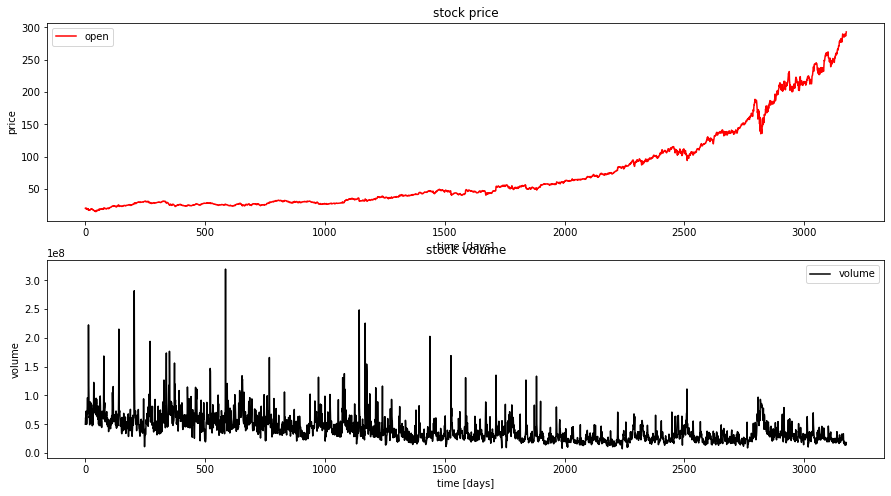

In [13]:
plt.figure(figsize=(15, 8));
plt.subplot(2,1,1);
symbol='MSFT'
plt.plot(df[(df.symbol == symbol)].Close.values, color='red', label='open')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(2,1,2);
plt.plot(df[df.symbol == symbol].Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49502 entries, 613773 to 401
Data columns (total 75 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   symbol                                    49502 non-null  object        
 1   Date                                      49502 non-null  datetime64[ns]
 2   Open                                      49502 non-null  float64       
 3   High                                      49502 non-null  float64       
 4   Low                                       49502 non-null  float64       
 5   Close                                     49502 non-null  float64       
 6   Volume                                    49502 non-null  int64         
 7   pct_change_next1                          49485 non-null  float64       
 8   pct_change_next2                          49468 non-null  float64       
 9   pct_change_next3         

In [9]:
df.isna().sum()

symbol                      0
Date                        0
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
sector                      0
Close_next10_max          170
label_next10_max            0
ext_feat_OpenClose          0
ext_feat_upOrDownInDay      0
ext_feat_OpenHigh           0
ext_feat_OpenLow            0
ext_feat_CloseHigh          0
ext_feat_CloseLow           0
ext_feat_HighLow            0
ext_feat_countUpDays      493
pct_change_price_lag1      17
pct_change_price_lag2      34
pct_change_price_lag3      51
pct_change_price_lag4      68
pct_change_price_lag5      85
pct_change_price_lag6     102
pct_change_price_lag7     119
pct_change_price_lag8     136
pct_change_price_lag9     153
pct_change_price_lag10    170
pct_change_price_lag11    187
pct_change_price_lag12    204
pct_change_price_lag13    221
pct_change_price_lag14    238
pct_change_price_lag15    255
pct_change

In [8]:
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter

df.head()

,symbol,Date,Open,High,Low,Close,Volume,sector,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter
43102,BID,2014-01-24,14.1816,14.5548,13.8084,14.0326,8417060,Financial Services,13.7340,0,-0.010507,0,0.026316,-0.026316,0.037213,-0.015977,0.054054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8417060.0,-3.360509e+06,NaN,NaN,NaN,1,1
43086,BID,2014-01-27,13.9577,14.0323,13.5098,13.7340,3240910,Financial Services,13.1369,0,-0.016027,0,0.005345,-0.032090,0.021720,-0.016324,0.038676,NaN,-0.021279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5176150.0,-3.820129e+06,NaN,NaN,NaN,1,1
43071,BID,2014-02-06,13.5845,13.6591,13.1366,13.1369,959590,Financial Services,12.6891,0,-0.032949,0,0.005492,-0.032971,0.039751,-0.000023,0.039774,NaN,-0.043476,-0.063830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4216560.0,-4.778617e+06,NaN,NaN,NaN,2,1
43055,BID,2014-02-07,12.9874,13.0620,12.3156,12.3905,2987600,Financial Services,12.6891,1,-0.045960,0,0.005744,-0.051727,0.054195,-0.006045,0.060606,NaN,-0.056817,-0.097823,-0.117020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1228960.0,-7.166616e+06,NaN,NaN,NaN,2,1
43039,BID,2014-02-10,12.3156,12.8381,12.0917,12.6891,4052090,Financial Services,12.6144,0,0.030327,1,0.042426,-0.018180,0.011742,-0.047080,0.061728,NaN,0.024099,-0.034087,-0.076081,-0.095741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5281050.0,-4.732321e+06,NaN,NaN,NaN,2,1


In [10]:
df['Date'].max()

Timestamp('2021-08-27 00:00:00')

In [11]:
df['Date'].min()

Timestamp('2008-01-02 00:00:00')

In [9]:
df = df[df['Date'] >= '2010-01-01']
df.dropna(inplace=True)
df.isna().sum()

symbol                    0
Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
sector                    0
Close_next10_max          0
label_next10_max          0
ext_feat_OpenClose        0
ext_feat_upOrDownInDay    0
ext_feat_OpenHigh         0
ext_feat_OpenLow          0
ext_feat_CloseHigh        0
ext_feat_CloseLow         0
ext_feat_HighLow          0
ext_feat_countUpDays      0
pct_change_price_lag1     0
pct_change_price_lag2     0
pct_change_price_lag3     0
pct_change_price_lag4     0
pct_change_price_lag5     0
pct_change_price_lag6     0
pct_change_price_lag7     0
pct_change_price_lag8     0
pct_change_price_lag9     0
pct_change_price_lag10    0
pct_change_price_lag11    0
pct_change_price_lag12    0
pct_change_price_lag13    0
pct_change_price_lag14    0
pct_change_price_lag15    0
pct_change_price_lag20    0
pct_change_price_lag30    0
pct_change_price_lag

In [13]:
df.isna().sum().sum()

0

In [14]:
df.describe()

,Open,High,Low,Close,Volume,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter
count,45426.000000,45426.000000,45426.000000,45426.000000,4.542600e+04,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,4.542600e+04,4.542600e+04,4.542600e+04,4.542600e+04,4.542600e+04,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000
mean,32.210354,32.627804,31.816160,32.229464,1.673801e+06,33.504855,0.683771,0.000771,0.550654,0.012941,-0.012102,0.012329,-0.012667,0.025472,16.537622,0.000883,0.001790,0.002711,0.003621,0.004529,0.005434,0.006346,0.007269,0.008194,0.009119,0.010052,0.010984,0.011900,0.012823,0.013758,0.018338,0.027703,0.037338,32.004214,31.657877,32.005687,31.667455,33.165494,32.186052,31.206610,52.127421,5.130842e+01,5.131170e+01,5.299634e+01,1.001691e+08,-1.467123e+07,26.132805,0.851834,0.911948,6.570973,2.522278
std,29.222439,29.591957,28.867797,29.243474,3.860003e+06,30.346753,0.465008,0.019228,0.497433,0.014632,0.013118,0.013336,0.014178,0.016811,3.722310,0.020602,0.029861,0.037080,0.042936,0.048130,0.052772,0.057031,0.061178,0.065087,0.068731,0.072268,0.075692,0.078941,0.082136,0.085308,0.099706,0.125023,0.148163,29.011333,28.671315,28.989888,28.625182,30.090113,29.204621,28.351804,12.931513,2.574773e+01,2.386152e+01,1.841083e+01,1.718993e+08,1.265694e+08,10.653274,0.860850,6.873109,3.393820,1.107317
min,1.041600,1.055000,1.021400,1.042400,1.000000e+01,1.129800,0.000000,-0.124837,0.000000,-0.041126,-0.125017,-0.002138,-0.130015,0.000000,3.000000,-0.110860,-0.134960,-0.194875,-0.250776,-0.265881,-0.301271,-0.310875,-0.352332,-0.352332,-0.370370,-0.413793,-0.414854,-0.420107,-0.420107,-0.409506,-0.450783,-0.487049,-0.522842,1.121425,1.229864,1.143314,1.268218,1.083344,1.051121,0.997748,6.071806,9.592327e-14,2.040837e-13,-3.115950e-12,-6.816555e+07,-6.669356e+08,5.894917,0.025902,-37.037022,1.000000,1.000000
25%,10.893700,11.000000,10.780000,10.897600,1.841025e+05,11.261600,0.000000,-0.008743,0.000000,0.002530,-0.016707,0.003291,-0.017544,0.014084,14.000000,-0.008823,-0.013056,-0.016092,-0.018183,-0.019999,-0.021484,-0.022988,-0.024625,-0.026073,-0.027510,-0.028494,-0.029648,-0.030868,-0.031496,-0.032891,-0.037979,-0.046774,-0.054215,10.868887,10.824500,10.867201,10.844184,11.172038,10.883166,10.617834,43.252261,2.960573e+01,3.163742e+01,3.981899e+01,1.305088e+07,-3.744467e+07,18.178413,0.252333,-2.750964,4.000000,2.000000
50%,18.105200,18.356600,17.884700,18.109000,5.551100e+05,18.836800,1.000000,0.000080,1.000000,0.008513,-0.008512,0.008840,-0.008261,0.020878,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001007,0.002244,0.003152,0.003778,0.004538,0.005404,0.005843,0.006337,0.006847,0.006994,0.008405,0.013050,0.018677,18.049703,17.861915,18.040705,17.846182,18.641074,18.112651,17.604802,51.713551,5.209698e+01,5.186096e+01,5.411860e+01,3.967015e+07,6.657052e+06,23.970590,0.471464,0.453810,7.

In [10]:
list_col_price = ['Open', 'High', 'Low', 'Close', 'Volume']
list_col_price_ta = [col for col in df.columns if 'ta_SMA' in col or 'ta_EMA' in col or 'ta_BBANDS' in col]

scaler = MinMaxScaler()
scaler.fit(df[list_col_price + list_col_price_ta])
df[list_col_price + list_col_price_ta] = scaler.transform(df[list_col_price + list_col_price_ta])

In [11]:
list_prefix = ['ta_MACD_macd', 'ta_OBV', 'ta_AD', 'ta_CCI']

for prefix in list_prefix:
    list_col_scale = [col for col in df.columns if prefix in col]
    
    if len(list_col_scale) == 0:
        continue
        
    scaler = StandardScaler()
    scaler.fit(df[list_col_scale])
    df[list_col_scale] = scaler.transform(df[list_col_scale])
    print(f'done {list_col_scale}')

done ['ta_OBV']
done ['ta_AD', 'ta_ADX']


In [12]:
df.max()

symbol                                    VNM
Date                      2021-08-13 00:00:00
Open                                      1.0
High                                      1.0
Low                                       1.0
Close                                     1.0
Volume                                    1.0
sector                             Technology
Close_next10_max                        176.6
label_next10_max                            1
ext_feat_OpenClose                   0.149445
ext_feat_upOrDownInDay                      1
ext_feat_OpenHigh                    0.149252
ext_feat_OpenLow                     0.069184
ext_feat_CloseHigh                   0.142645
ext_feat_CloseLow                         0.0
ext_feat_HighLow                     0.149533
ext_feat_countUpDays                     30.0
pct_change_price_lag1                0.093227
pct_change_price_lag2                0.144581
pct_change_price_lag3                0.224228
pct_change_price_lag4             

In [16]:
gc.collect()

45

In [12]:
train_cols = ['Open', 'High', 'Low', 'Close', 
              'Volume',
              'month', 'quarter'
             ]

category_cols = ['symbol',]

ta_cols = [col for col in df.columns if 'ta_' in col]
ext_feature_cols = [col for col in df.columns if 'ext_feat_' in col]
pct_change_lag_cols = [col for col in df.columns if 'pct_change_price_lag' in col]

label = 'label_next10_max'

In [13]:
for col in category_cols:
    le = preprocessing.LabelEncoder()
    df['encode_' + col] = le.fit_transform(df[col])
    train_cols.append('encode_' + col)
    print(f'processed column {col}')

processed column symbol


In [14]:
df = df[df['Date'] >= '2010-01-01']
df.dropna(inplace=True)
df.isna().sum().sum()

0

In [20]:
df.head()

,symbol,Date,Open,High,Low,Close,Volume,label_next1,label_next2,label_next3,Close_next10_max,label_next10_max,Close_next3to10_max,label_next3to10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_EMA100,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,encode_symbol
588992,BID,2014-06-27,0.057539,0.057816,0.059451,0.058946,0.002955,0,0,0,11.3455,0,11.3455,0,0.013353,1,0.013335,0.000000,-0.000018,-0.013177,0.013335,25.0,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.027030,0.041091,-0.037979,0.058571,0.059150,0.059311,0.060300,0.064170,0.072891,0.059112,0.059338,0.059671,0.060182,0.063957,0.071130,0.055719,0.058828,0.059206,-0.127621,-0.187157,0.164532,59.314120,83.392879,88.028499,86.782328,-0.519178,-0.029145,6,2,0
588747,BID,2014-06-30,0.058382,0.057816,0.059451,0.058946,0.002595,0,0,0,11.3455,0,11.3455,0,0.000018,1,0.000000,-0.013160,-0.000018,-0.013177,0.013335,25.0,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.048277,-0.025644,0.058855,0.059410,0.059443,0.060435,0.064094,0.072708,0.059293,0.059542,0.059855,0.060309,0.063965,0.071057,0.055862,0.059089,0.059581,-0.114664,-0.173780,0.165755,59.314120,76.725322,83.023864,85.887963,-0.519178,-0.027044,6,2,0
588503,BID,2014-07-01,0.057960,0.057399,0.059451,0.058521,0.003760,0,0,0,11.3455,0,11.3455,0,0.000027,1,0.000000,-0.006619,-0.000027,-0.006645,0.006663,25.0,-0.006575,-0.006575,0.000000,0.006672,0.006672,0.013424,0.027214,0.013424,0.013424,0.013424,0.013424,0.013424,0.013424,0.027214,0.027214,0.041384,0.027214,-0.006575,0.058855,0.059497,0.059530,0.060570,0.063998,0.072540,0.059169,0.059534,0.059926,0.060381,0.063955,0.070976,0.055916,0.059273,0.059896,-0.110595,-0.162214,0.142661,55.286657,74.508258,78.208820,76.617321,-0.521402,-0.023984,7,3,0
588255,BID,2014-07-02,0.057960,0.058233,0.059451,0.058946,0.006505,0,0,0,11.3455,0,11.1962,0,0.006646,1,0.013247,-0.006619,0.006558,-0.013177,0.019998,25.0,0.006619,0.000000,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.048277,0.020132,-0.019353,0.058855,0.059670,0.059661,0.060728,0.063931,0.072418,0.059322,0.059674,0.060064,0.060489,0.063963,0.070907,0.055847,0.059421,0.060274,-0.102141,-0.151165,0.136065,58.333468,73.401215,74.878265,77.931035,-0.517555,-0.022222,7,3,0
588009,BID,2014-07-03,0.058382,0.058233,0.059885,0.058946,0.003913,0,0,0,11.3455,0,11.1962,0,0.000018,1,0.006575,-0.006584,0.006558,-0.006602,0.013247,26.0,0.000000,0.006619,0.000000,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.048277,0.041091,0.041091,0.058855,0.059756,0.059792,0.060886,0.063903,0.072347,0.059398,0.059766,0.060177,0.060587,0.063972,0.070838,0.055885,0.059540,0.060473,-0.096044,-0.141031,0.124401,58.333468,68.970072,72.293182,77.281022,-0.517555,-0.022211,7,3,0


In [15]:
df_list_date = pd.DataFrame(df['Date'].unique(), columns=['Date'])

In [16]:
# def calc_cum_effect(series, num_day=0):
#     result = series
#     if num_day > 0:
#         for i in range(1, num_day + 1):
#             result += 1/i * series.shift(i, fill_value=0)
#     return result

df_stock_news = pd.read_csv('./exported_data/news_sentiment_analysis/vn_stock_news_sentiment_analysis.csv')
df_stock_news['Date'] = pd.to_datetime(df_stock_news['Date'])

stock_news_cols = [col for col in df_stock_news.columns if col not in ['symbol', 'Date']]

df_stock_news = df_list_date.merge(df_stock_news, on='Date', how='outer')
df_stock_news = df_stock_news.sort_values(by=['symbol', 'Date'])
df_stock_news.fillna(0, inplace=True)

# for col in stock_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_stock_news[col] = df_stock_news \
#             .groupby('symbol')[col].transform(calc_cum_effect)

df_stock_news.head()

,Date,symbol,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader
972,2018-03-12,ACB,0.0,1.0
997,2018-04-12,ACB,-1.0,1.0
1039,2018-06-12,ACB,-1.0,1.0
1063,2018-07-12,ACB,0.0,1.0
11891,2018-08-12,ACB,-1.0,-1.0


In [17]:
df_political_news = pd.read_csv('./exported_data/news_sentiment_analysis/vn_political_news_sentiment_analysis.csv')
df_political_news['Date'] = pd.to_datetime(df_political_news['Date'])
political_news_cols = [col for col in df_political_news.columns if col not in ['symbol', 'Date']]

df_political_news = df_list_date.merge(df_political_news, on='Date', how='outer')
df_political_news = df_political_news.sort_values(by=['Date'])
df_political_news.fillna(0, inplace=True)

# for col in political_news_cols:
#     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
#         df_political_news[col] = df_political_news[col].transform(calc_cum_effect)
        
df_political_news.head()

,Date,politic_daily_sentiment_score_vader
2896,2005-01-06,0.333333
2897,2005-01-08,1.000000
2898,2005-01-10,1.000000
2899,2005-01-11,0.666667
2900,2005-01-12,1.000000


In [23]:
# df_political_news_us = pd.read_csv('./exported_data/news_sentiment_analysis/us_political_news_sentiment_analysis.csv')
# df_political_news_us['Date'] = pd.to_datetime(df_political_news_us['Date'])

# df_political_news_us.columns = [col + '_us' if col not in ['symbol', 'Date'] else col for col in df_political_news_us.columns]

# political_news_cols_us = [col for col in df_political_news_us.columns if col not in ['symbol', 'Date']]

# df_political_news_us = df_list_date.merge(df_political_news_us, on='Date', how='outer')
# df_political_news_us = df_political_news_us.sort_values(by=['Date'])
# df_political_news_us.fillna(0, inplace=True)

# # for col in political_news_cols:
# #     if '_pos' in col or '_neg' in col or '_compound' in col or '_total' in col:
# #         df_political_news[col] = df_political_news[col].transform(calc_cum_effect)
        
# df_political_news_us.head()

,Date,political_news_in_day_us,political_news_vader_neg_us,political_news_vader_pos_us,political_news_vader_neu_us,political_news_vader_compound_us
2896,2005-01-02,1.0,0.494,0.000,0.506,-0.5994
2897,2005-01-03,1.0,0.000,0.000,1.000,0.0000
2898,2005-01-05,1.0,0.630,0.000,0.370,-0.6249
2899,2005-01-06,2.0,0.830,0.131,1.039,-1.1951
2900,2005-01-07,1.0,0.615,0.000,0.385,-0.7506


In [18]:
df = df.merge(df_stock_news, on=['symbol', 'Date'], how='left')
df = df.merge(df_political_news, on=['Date'], how='left')
# df = df.merge(df_political_news_us, on=['Date'], how='left')

df.head()

,symbol,Date,Open,High,Low,Close,Volume,sector,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,encode_symbol,stock_daily_sentiment_score_lm,stock_daily_sentiment_score_vader,politic_daily_sentiment_score_vader
0,BID,2014-04-15,0.064023,0.063798,0.065825,0.064215,0.004805,Financial Services,12.0173,0,-0.005997,0,0.006029,-0.006021,0.012098,-0.000024,0.012123,19.0,-0.011969,-0.006021,-0.011969,-0.011969,-0.017855,-0.023663,-0.017855,-0.011969,-0.011969,-0.017855,-0.029411,-0.017855,-0.017855,-0.040691,-0.062496,-0.006021,-0.011969,-0.011969,0.069617,0.072822,0.068294,0.071422,0.061926,0.065683,0.066428,38.178623,25.083724,32.491953,19.392890,-0.528913,-0.029787,-0.956868,0.209150,-1.785515,4,2,0,NaN,NaN,0.0
1,BID,2014-04-16,0.063602,0.062963,0.062780,0.062089,0.010653,Financial Services,12.0173,0,-0.030287,0,0.000000,-0.042426,0.031233,-0.012518,0.044306,18.0,-0.030310,-0.041917,-0.036149,-0.041917,-0.041917,-0.047624,-0.053257,-0.047624,-0.041917,-0.041917,-0.047624,-0.058830,-0.047624,-0.047624,-0.069768,-0.047624,-0.036149,-0.036149,0.069437,0.072555,0.067956,0.071258,0.062972,0.065242,0.064394,30.071387,23.398974,28.226255,21.266923,-0.535109,-0.033386,-0.809351,0.231553,-4.191703,4,2,0,NaN,NaN,0.0
2,BID,2014-04-17,0.061497,0.062546,0.063650,0.062515,0.006812,Financial Services,11.8680,0,0.006272,1,0.025003,0.000000,0.018615,-0.006233,0.025003,19.0,0.006255,-0.024245,-0.035924,-0.030120,-0.035924,-0.035924,-0.041667,-0.047335,-0.041667,-0.035924,-0.035924,-0.041667,-0.052943,-0.041667,-0.041667,-0.074710,-0.030120,-0.030120,0.069144,0.072335,0.067693,0.071120,0.062596,0.064687,0.063673,33.131392,16.722486,21.735061,28.430218,-0.531147,-0.036068,-0.672370,0.236342,-3.592430,4,2,0,NaN,NaN,0.0
3,BID,2014-04-18,0.061918,0.061711,0.063215,0.061664,0.007635,Financial Services,11.8680,0,-0.012399,0,0.006216,-0.012416,0.018849,-0.000017,0.018866,18.0,-0.012424,-0.006247,-0.036368,-0.047902,-0.042169,-0.047902,-0.047902,-0.053573,-0.059170,-0.053573,-0.047902,-0.047902,-0.053573,-0.064709,-0.053573,-0.101699,-0.042169,-0.059170,0.068738,0.072172,0.067369,0.070950,0.062236,0.064055,0.062778,30.279460,20.033941,20.051800,21.400122,-0.535588,-0.042088,-0.526160,0.235453,-5.357342,4,2,0,NaN,NaN,0.0
4,BID,2014-04-21,0.061076,0.060459,0.061040,0.059963,0.005660,Financial Services,11.8680,1,-0.025144,0,0.000000,-0.031446,0.025792,-0.006465,0.032467,17.0,-0.025160,-0.037271,-0.031249,-0.060613,-0.071857,-0.066269,-0.071857,-0.071857,-0.077386,-0.082842,-0.077386,-0.071857,-0.071857,-0.077386,-0.088241,-0.114291,-0.066269,-0.071857,0.068286,0.072067,0.066906,0.070713,0.061606,0.063251,0.061826,25.543623,15.927101,17.561176,22.069679,-0.538880,-0.044767,-0.311950,0.245307,-8.284183,4,2,0,NaN,NaN,0.0


In [19]:
df[stock_news_cols] = df[stock_news_cols].fillna(0)
df[political_news_cols] = df[political_news_cols].fillna(0)
# df[political_news_cols_us] = df[political_news_cols_us].fillna(0)

In [21]:
# for col in df.columns:
#     if 'obj' in col:
#         if col in stock_news_cols:
#             stock_news_cols.remove(col)
#         if col in political_news_cols:
#             political_news_cols.remove(col)
#         if col in political_news_cols_us:
#             political_news_cols_us.remove(col)
# #         if col in stock_market_news_cols:
# #             stock_market_news_cols.remove(col) 

In [28]:
df.describe()

,Open,High,Low,Close,Volume,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_lm_pos,stock_news_lm_neg,stock_news_lm_polar,stock_news_lm_subject,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_in_day_us,political_news_vader_neg_us,political_news_vader_pos_us,political_news_vader_neu_us,political_news_vader_compound_us
count,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,4.542600e+04,4.542600e+04,4.542600e+04,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000,45426.000000
mean,0.176060,0.176781,0.179611,0.177871,0.016742,33.504855,0.683771,0.000771,0.550654,0.012941,-0.012102,0.012329,-0.012667,0.025472,16.537622,0.000883,0.001790,0.002711,0.003621,0.004529,0.005434,0.006346,0.007269,0.008194,0.009119,0.010052,0.010984,0.011900,0.012823,0.013758,0.018338,0.027703,0.037338,0.186935,0.195207,0.185333,0.192118,0.173502,0.179941,0.177555,52.127421,5.130842e+01,5.131170e+01,5.299634e+01,0.035159,-0.012286,-0.023468,0.851834,0.911948,6.570973,2.522278,8.216946,0.311187,0.012289,0.029448,0.269452,0.075424,0.000135,0.006888,-0.139885,0.007022,0.007132,0.000162,0.000884,0.006087,0.002946,9.262031,1.079546,0.716245,7.466253,-0.654757
std,0.164814,0.165413,0.168221,0.166529,0.038608,30.346753,0.465008,0.019228,0.497433,0.014632,0.013118,0.013336,0.014178,0.016811,3.722310,0.020602,0.029861,0.037080,0.042936,0.048130,0.052772,0.057031,0.061178,0.065087,0.068731,0.072268,0.075692,0.078941,0.082136,0.085308,0.099706,0.125023,0.148163,0.175271,0.183477,0.173739,0.180225,0.162523,0.168595,0.166502,12.931513,2.574773e+01,2.386152e+01,1.841083e+01,1.022966,1.031123,0.970058,0.860850,6.873109,3.393820,1.107317,4.915580,1.005161,0.054620,0.108051,0.870412,0.381721,0.002100,0.028758,0.547192,0.029144,0.145048,0.004824,0.021320,0.122834,0.074204,6.250085,0.832292,0.663909,5.130647,1.400112
min,0.000269,0.000296,0.000160,0.000274,0.000000,1.129800,0.000000,-0.124837,0.000000,-0.041126,-0.125017,-0.002138,-0.130015,0.000000,3.000000,-0.110860,-0.134960,-0.194875,-0.250776,-0.265881,-0.301271,-0.310875,-0.352332,-0.352332,-0.370370,-0.413793,-0.414854,-0.420107,-0.420107,-0.409506,-0.450783,-0.487049,-0.522842,0.000358,0.000488,0.000372,0.000723,0.000219,0.000202,0.000147,6.071806,9.592327e-14,2.040837e-13,-3.115950e-12,-0.966594,-5.326092,-1.866274,0.025902,-37.037022

In [29]:
df.isna().sum().sum()

0

In [95]:
# del data_train_valid, data_test
# del data_train, data_valid
# del X_train_val, y_train_val
del X_train, X_valid, y_train, y_valid
del X_test, y_test
del dtrain, dvalid
gc.collect()

230

In [29]:
df.shape

(47649, 85)

In [22]:
df['Date'].min()

Timestamp('2010-01-04 00:00:00')

In [31]:
df['Date'].max()

Timestamp('2021-08-13 00:00:00')

In [19]:
df.head()

,symbol,Date,Open,High,Low,Close,Volume,pct_change_next1,pct_change_next2,pct_change_next3,label_next1,label_next2,label_next3,Close_next10_max,label_next10_max,Close_next3to10_max,label_next3to10_max,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag16,pct_change_price_lag17,pct_change_price_lag18,pct_change_price_lag19,pct_change_price_lag20,pct_change_price_lag21,pct_change_price_lag22,pct_change_price_lag23,pct_change_price_lag24,pct_change_price_lag25,pct_change_price_lag26,pct_change_price_lag27,pct_change_price_lag28,pct_change_price_lag29,pct_change_price_lag30,pct_change_price_OpenClose,pct_change_price_OpenClose_upOrDownInDay,pct_change_price_OpenClose_CE,pct_change_price_OpenClose_FL,pct_change_price_rangeInDay,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,encode_symbol
588992,BID,2014-06-27,2.415557,2.428804,2.415557,2.428821,12.596221,0.000000,-0.006575,0.000000,0,0,0,11.3455,0,11.3455,0,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.048277,0.048277,0.048277,0.041091,0.027030,0.020132,0.020132,0.013335,0.041091,0.034013,0.041091,0.020132,0.034013,0.048277,0.041091,0.013353,1,0,0,0.013335,2.422221,2.418240,2.412238,2.401816,2.414243,2.475919,2.423252,2.419457,2.413555,2.409021,2.425837,2.429984,2.416491,2.402813,0.021707,-0.030539,0.052247,59.314120,83.392879,88.028499,86.782328,-0.519178,-0.029145,6,2,0
588747,BID,2014-06-30,2.428804,2.428804,2.415557,2.428821,12.466435,-0.006575,0.000000,0.000000,0,0,0,11.3455,0,11.3455,0,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.048277,0.048277,0.048277,0.041091,0.027030,0.020132,0.020132,0.013335,0.041091,0.034013,0.041091,0.020132,0.034013,0.048277,0.000018,1,0,0,0.013335,2.426627,2.422221,2.414243,2.403842,2.413174,2.473657,2.426040,2.422588,2.416348,2.410924,2.425954,2.432321,2.420523,2.408583,0.035241,-0.017383,0.052624,59.314120,76.725322,83.023864,85.887963,-0.519178,-0.027044,6,2,0
588503,BID,2014-07-01,2.422198,2.422198,2.415557,2.422224,12.837158,0.006619,0.006619,0.006619,0,0,0,11.3455,0,11.3455,0,-0.006575,-0.006575,0.000000,0.006672,0.006672,0.013424,0.027214,0.013424,0.013424,0.013424,0.013424,0.013424,0.013424,0.027214,0.027214,0.041384,0.034246,0.041384,0.041384,0.041384,0.034246,0.020277,0.013424,0.013424,0.006672,0.034246,0.027214,0.034246,0.013424,0.027214,0.000027,1,0,0,0.006663,2.426627,2.423545,2.415577,2.405863,2.411837,2.471579,2.424134,2.422467,2.417419,2.412006,2.425808,2.433199,2.423347,2.413397,0.039491,-0.006008,0.045500,55.286657,74.508258,78.208820,76.617321,-0.521402,-0.023984,7,3,0
588255,BID,2014-07-02,2.422198,2.435357,2.415557,2.428821,13.385374,0.000000,0.000000,-0.013159,0,0,0,11.3455,0,11.1962,0,0.006619,0.000000,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.048277,0.048277,0.048277,0.041091,0.027030,0.020132,0.020132,0.013335,0.041091,0.034013,0.041091,0.020132,0.006646,1,0,0,0.019998,2.426627,2.426188,2.417575,2.408217,2.410900,2.470065,2.426480,2.424589,2.419502,2.413620,2.425926,2.432066,2.425624,2.419140,0.048322,0.004858,0.043465,58.333468,73.401215,74.878265,77.931035,-0.517555,-0.022222,7,3,0
588009,BID,2014-07-03,2.428804,2.435357,2.422198,2.428821,12.877128,0.000000,-0.013159,-0.026319,0,0,0,11.3455,0,11.1962,0,0.000000,0.00661

In [27]:
# label = 'Close_next10_max'
label

'label_next10_max'

# train test split

In [20]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01'
test_date_start = '2021-05-01' #'2021-05-01'
test_date_end = '2021-07-31'

# df = make_train_test_split(df, test_date_start=test_date_start, each_valid_size=30, train_valid_ratio=5)

data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start)]
data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)]
data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

# data_train = df[df['make_split_train_test'] == 'train']
# data_valid = df[df['make_split_train_test'] == 'valid']
# data_test = df[df['make_split_train_test'] == 'test']

data_train = shuffle(data_train).reset_index(drop=True)

In [34]:
print('train shape', data_train.shape)
print('valid shape', data_valid.shape)
# print('train valid shape', data_train_valid.shape)
print('test shape', data_test.shape)

print(f'valid ratio {data_valid.shape[0] / (data_valid.shape[0] + data_train.shape[0])}')

train shape (37088, 85)
valid shape (6730, 85)
test shape (1088, 85)
valid ratio 0.15358984892053493


In [37]:
data_prediction = data_test[['symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
data_prediction.head(1)

,symbol,Date,Open,High,Low,Close,Volume
1708,BID,2021-05-04,0.219993,0.228051,0.2273,0.229524,0.021724


In [47]:
df.head()

,symbol,Date,Open,High,Low,Close,Volume,label_next1,label_next2,label_next3,Close_next10_max,label_next10_max,Close_next3to10_max,label_next3to10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_SMA100,ta_EMA3,ta_EMA5,ta_EMA10,ta_EMA20,ta_EMA50,ta_EMA100,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,month,quarter,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total
0,BID,2014-06-27,0.057539,0.057816,0.059451,0.058946,0.002955,0,0,0,11.3455,0,11.3455,0,0.013353,1,0.013335,0.000000,-0.000018,-0.013177,0.013335,25.0,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.027030,0.041091,-0.037979,0.058571,0.059150,0.059311,0.060300,0.064170,0.072891,0.059112,0.059338,0.059671,0.060182,0.063957,0.071130,0.055719,0.058828,0.059206,-0.127621,-0.187157,0.164532,59.314120,83.392879,88.028499,86.782328,-0.519178,-0.029145,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BID,2014-06-30,0.058382,0.057816,0.059451,0.058946,0.002595,0,0,0,11.3455,0,11.3455,0,0.000018,1,0.000000,-0.013160,-0.000018,-0.013177,0.013335,25.0,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.034013,0.048277,0.041091,0.048277,-0.025644,0.058855,0.059410,0.059443,0.060435,0.064094,0.072708,0.059293,0.059542,0.059855,0.060309,0.063965,0.071057,0.055862,0.059089,0.059581,-0.114664,-0.173780,0.165755,59.314120,76.725322,83.023864,85.887963,-0.519178,-0.027044,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BID,2014-07-01,0.057960,0.057399,0.059451,0.058521,0.003760,0,0,0,11.3455,0,11.3455,0,0.000027,1,0.000000,-0.006619,-0.000027,-0.006645,0.006663,25.0,-0.006575,-0.006575,0.000000,0.006672,0.006672,0.013424,0.027214,0.013424,0.013424,0.013424,0.013424,0.013424,0.013424,0.027214,0.027214,0.041384,0.027214,-0.006575,0.058855,0.059497,0.059530,0.060570,0.063998,0.072540,0.059169,0.059534,0.059926,0.060381,0.063955,0.070976,0.055916,0.059273,0.059896,-0.110595,-0.162214,0.142661,55.286657,74.508258,78.208820,76.617321,-0.521402,-0.023984,7,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BID,2014-07-02,0.057960,0.058233,0.059451,0.058946,0.006505,0,0,0,11.3455,0,11.1962,0,0.006646,1,0.013247,-0.006619,0.006558,-0.013177,0.019998,25.0,0.006619,0.000000,0.000000,0.006619,0.013335,0.013335,0.020132,0.034013,0.020132,0.020132,0.020132,0.020132,0.020132,0.020132,0.034013,0.048277,0.020132,-0.019353,0.058855,0.059670,0.059661,0.060728,0.063931,0.072418,0.059322,0.059674,0.060064,0.060489,0.063963,0.070907,0.055847,0.059421,0.060274,-0.102141,-0.151165,0.136065,58.333468,73.401215,74.878265,77.931035,-0.517555,-0.022222,7,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BID,2014-07-03,0.058382,0.058233,0.059885,0.058946,0.003913,0,0,0,11.3455,0,11.1962,0,0.000018,1

In [30]:
# X_train = data_train[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

#X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
# X_train = data_train[train_cols + ext_feature_cols + pct_change_lag_cols]
X_train = data_train[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_train = data_train[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_train = data_train[[label]]

In [31]:
# X_valid = data_valid[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                      stock_news_cols + stock_market_news_cols +
#                      political_news_cols + indicator_news_cols]

# X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
# X_valid = data_valid[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_valid = data_valid[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_valid = data_valid[[label]]

In [32]:
# X_test = data_test[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols +
#                    stock_news_cols + stock_market_news_cols + 
#                    political_news_cols + indicator_news_cols]

# X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
# X_test = data_test[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols]
X_test = data_test[train_cols + ext_feature_cols + pct_change_lag_cols + ta_cols]

y_test = data_test[[label]]

# Random forest

In [33]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion="entropy")
rfc.fit(X_train, y_train)

<ipython-input-33-a94fb55c803a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_jobs=-1)

f1 score: 0.6630360789652825
accuracy score: 0.5450367647058824
              precision    recall  f1-score   support

           0       0.23      0.43      0.30       249
           1       0.77      0.58      0.66       839

    accuracy                           0.55      1088
   macro avg       0.50      0.50      0.48      1088
weighted avg       0.65      0.55      0.58      1088



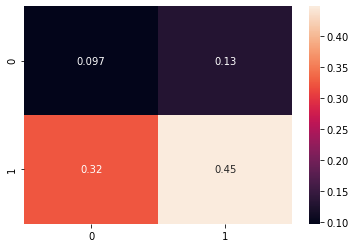

In [34]:
threshold = 0.6
y_pred = (rfc.predict_proba(X_test)[:, 1] >= threshold).astype('int')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# LightGBM

In [31]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_leaves": 50,
#     "max_bin": 32,
    "feature_fraction": 0.8,
#     "bagging_fraction" : 0.9,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": True,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" :  "binary_logloss"
    # "metric" : "rmse"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=2000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=10,
                  early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 24956, number of negative: 12132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13580
[LightGBM] [Info] Number of data points in the train set: 37088, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.672886 -> initscore=0.721268
[LightGBM] [Info] Start training from score 0.721268
Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.628355	valid_1's binary_logloss: 0.590972
[20]	training's binary_logloss: 0.624789	valid_1's binary_logloss: 0.59016
[30]	training's binary_logloss: 0.62152	valid_1's binary_logloss: 0.589803
[40]	training's binary_logloss: 0.618587	valid_1's binary_logloss: 0.589333
[50]	training's binary_logloss: 0.615826	valid_1's binary_logloss: 0.589041
[60]	training's binary_logloss: 0.613283	valid_1's binary_loglos

In [32]:
model.predict(X_valid)

array([0.68440292, 0.68640479, 0.68876505, ..., 0.65962869, 0.66300171,
       0.69136065])

0.7948374760994262
              precision    recall  f1-score   support

           0       0.23      0.36      0.28      1175
           1       0.85      0.75      0.79      5555

    accuracy                           0.68      6730
   macro avg       0.54      0.56      0.54      6730
weighted avg       0.74      0.68      0.71      6730



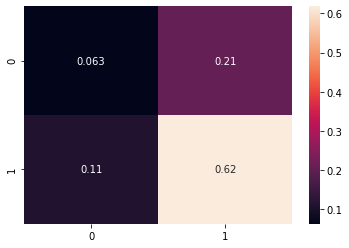

In [34]:
threshold = 0.65
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f1_score(y_valid_pred, y_valid))
print(classification_report(y_valid_pred, y_valid))

cm = confusion_matrix(y_valid, y_valid_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

f1 score: 0.8282716731087797
accuracy score: 0.7141544117647058
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       249
           1       0.77      0.89      0.83       839

    accuracy                           0.71      1088
   macro avg       0.50      0.50      0.49      1088
weighted avg       0.65      0.71      0.67      1088



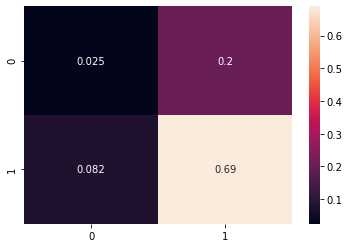

In [35]:
threshold = 0.65
y_pred = (model.predict(X_test) >= threshold).astype('int')

# print(f'sector = {sector}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [37]:
data_test['predict'] = y_pred

<ipython-input-37-c800d0237547>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict'] = y_pred


In [38]:
data_test[(data_test['Date'] >= '2021-07-01') & (data_test['Date'] < '2021-08-01')][[
    'Date', 'symbol',
    'Open', 'High', 'Low', 'Close', 'Volume',
    'label_next10_max', 'predict'
]].to_csv('./exported_data/vn_prediction_202107_20210907.csv')

In [67]:
# train_valid_date_start = '2015-01-01'
# # valid_date_start = '2020-01-01'
# test_date_start = '2021-04-01'
# test_date_end = '2021-07-31'

# data_train_valid = df[(df["Date"] >= train_valid_date_start) & (df["Date"] < test_date_start)]
# data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

In [75]:
list_cols_training = train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

In [81]:
kf = KFold(n_splits=5)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
#     "num_leaves": 50,
#     "max_bin": 32,
    "feature_fraction": 0.55,
    "bagging_fraction" : 0.55,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

models = []

for fold, (train_index, _) in enumerate(kf.split(data_train)):
    X_train = data_train.iloc[train_index][train_cols + pct_change_lag_cols + ta_cols]
    y_train = data_train.iloc[train_index][[label]]
    
#     X_valid = data_train_valid.iloc[valid_index][list_cols_training]
#     y_valid = data_train_valid.iloc[valid_index][label]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)
    
    print('*' * 50)
    print(f'training with fold {fold}')
    
    model = lgb.train(params=params, 
                      train_set=dtrain, 
                      num_boost_round=5000, 
                      valid_sets=[dtrain, dvalid], 
                      verbose_eval=20,
                      early_stopping_rounds=100)
     
    models.append(model)

**************************************************
training with fold 0
[LightGBM] [Info] Number of positive: 21203, number of negative: 10421
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22477
[LightGBM] [Info] Number of data points in the train set: 31624, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670472 -> initscore=0.710320
[LightGBM] [Info] Start training from score 0.710320
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.587658	valid_1's binary_logloss: 0.599344
[40]	training's binary_logloss: 0.562284	valid_1's binary_logloss: 0.607847
[60]	training's binary_logloss: 0.539108	valid_1's binary_logloss: 0.612151
[80]	training's binary_logloss: 0.519061	valid_1's binary_logloss: 0.617826
[100]	training's binary_logloss: 0.499563	valid_1's binary_logloss

f1 score: 0.8215609208309939
accuracy score: 0.7083868599743072
              precision    recall  f1-score   support

           0       0.36      0.14      0.20      1434
           1       0.75      0.91      0.82      4015

    accuracy                           0.71      5449
   macro avg       0.55      0.53      0.51      5449
weighted avg       0.65      0.71      0.66      5449



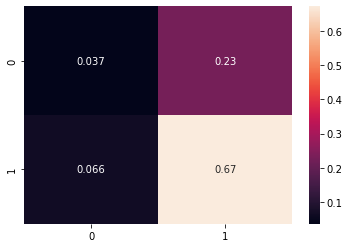

In [83]:
preds = []

threshold = 0.65

for model in models:
    pred = model.predict(X_valid)
    preds.append(pred)
    
y_pred_valid = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

# print(f'sector = {sector}')
print(f'f1 score: {f1_score(y_valid, y_pred_valid)}')
print(f'accuracy score: {accuracy_score(y_valid, y_pred_valid)}')
print(classification_report(y_valid, y_pred_valid))

cm = confusion_matrix(y_valid, y_pred_valid, normalize='all')
f = sns.heatmap(cm, annot=True)

In [88]:
preds = []
threshold = 0.4

for model in models:
    pred = model.predict(X_test)
    preds.append(pred)
    
y_pred = (np.array(preds).T.mean(axis=1) >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.88      0.76     20404
           1       0.43      0.17      0.24     10912

    accuracy                           0.63     31316
   macro avg       0.55      0.52      0.50     31316
weighted avg       0.58      0.63      0.58     31316



In [89]:
tmp = pd.DataFrame(y_pred, columns=['label']).groupby('label').size().reset_index()
tmp['percent'] = tmp[0] / tmp[0].sum()
tmp

,label,0,percent
0,0,27000,0.862179
1,1,4316,0.137821


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

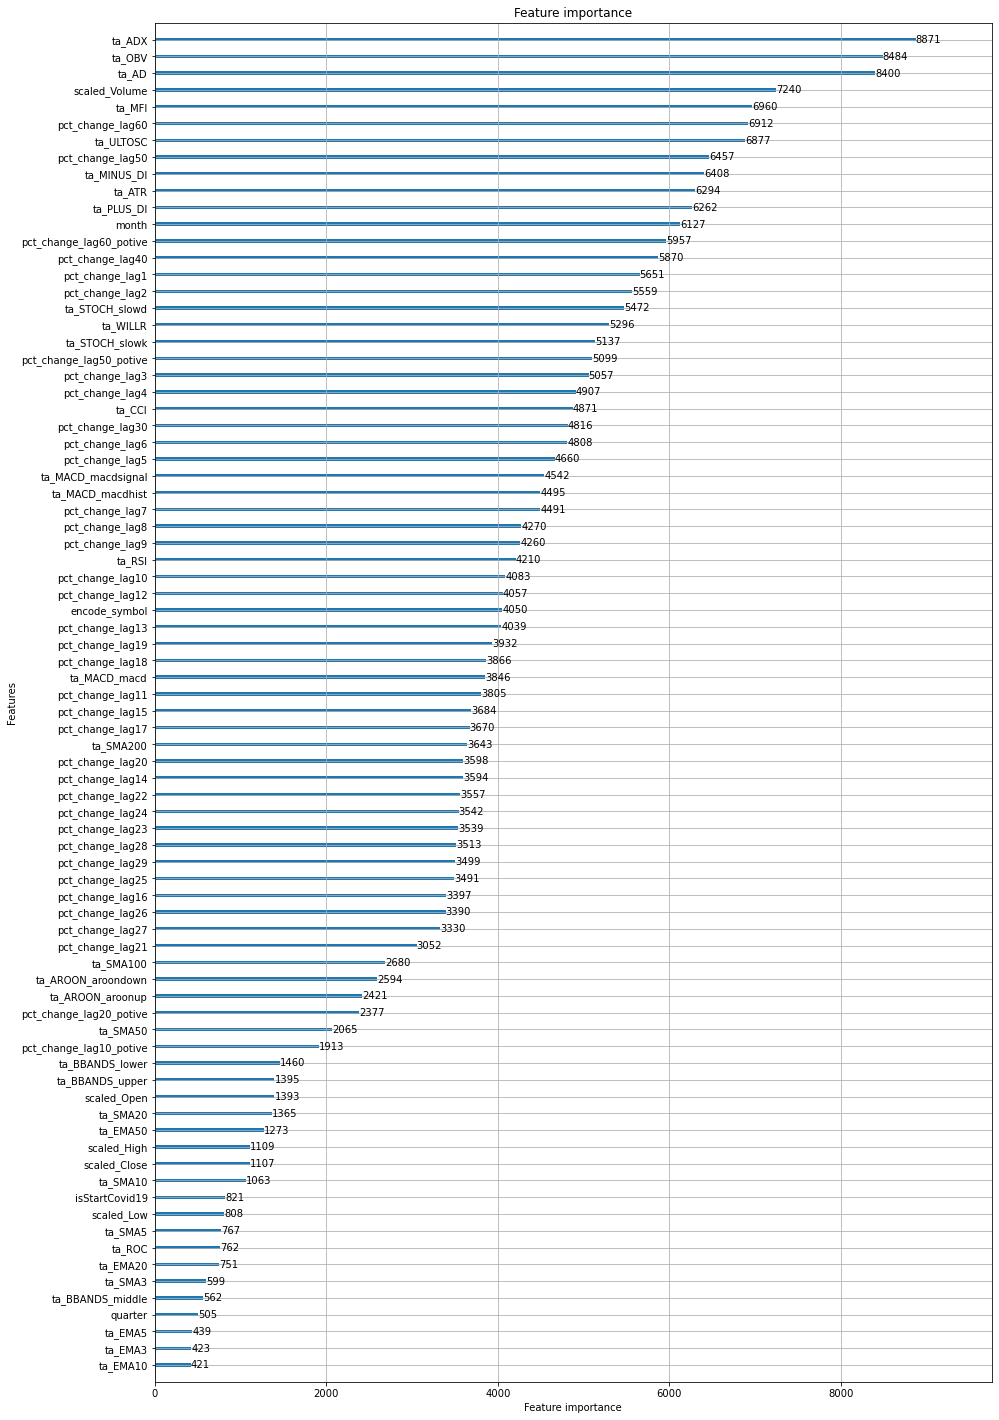

In [112]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

In [74]:
# train_valid_date_start = '2015-01-01'
# # valid_date_start = '2020-01-01'
# test_date_start = '2021-04-01'
# test_date_end = '2021-07-31'

# data_train_valid = df[(df["Date"] >= train_valid_date_start) & (df["Date"] < test_date_start)]
# data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)]

In [90]:
list_cols_training = train_cols + pct_change_lag_cols + ta_cols + \
                       stock_news_cols + stock_market_news_cols + \
                       political_news_cols + indicator_news_cols

label = ['label']

# XGBoost

In [109]:
params = {'objective':'binary:logistic',
#           'max_depth': 6, # default 6
          'alpha': 10,
#           'gamma' : 0, # default 0
#           'subsample' : 1, # default 1
#           'colsample_bytree' : 1, # default 1
#           'min_child_weight' : 1, # default 1
          'learning_rate': 0.1,
#           'alpha' : 0, # default 0
#           'eval_metric' : 'logloss',
          'n_estimators' : 1000,
          'verbosity' : 1,
          'seed' : 10
         }

model = XGBClassifier(**params) 
model.fit(X_train, y_train,
          eval_metric="logloss",
          eval_set=[(X_train, y_train), (X_valid, y_valid)], 
          early_stopping_rounds=200,
          verbose=100)

[0]	validation_0-logloss:0.68166	validation_1-logloss:0.68669


/home/tuongnguyen/anaconda3/envs/jupyterNotebook3.9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/tuongnguyen/anaconda3/envs/jupyterNotebook3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	validation_0-logloss:0.55081	validation_1-logloss:0.67190
[200]	validation_0-logloss:0.49592	validation_1-logloss:0.68090
[217]	validation_0-logloss:0.48766	validation_1-logloss:0.68273


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=10, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
              seed=10, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=1)

In [46]:
data_prediction[label] = data_test[label]
data_prediction.head()

,symbol,Date,Open,High,Low,Close,Volume,label_next10_max,predict_label_next10_max_xgboost,label_next3
1708,BID,2021-05-04,0.219993,0.228051,0.227300,0.229524,0.021724,1,0.683844,0
1709,BID,2021-05-05,0.229581,0.231126,0.236041,0.232941,0.026928,1,0.674321,0
1710,BID,2021-05-06,0.230709,0.228610,0.234293,0.229239,0.022466,1,0.657077,1
1711,BID,2021-05-07,0.223377,0.224697,0.230214,0.225822,0.037074,1,0.690222,1
1712,BID,2021-05-10,0.222813,0.226374,0.229340,0.230093,0.030284,1,0.686456,1


In [47]:
data_prediction[f'predict_{label}_xgboost'] = model.predict_proba(X_test)[:, 1] 
data_prediction.head()

,symbol,Date,Open,High,Low,Close,Volume,label_next10_max,predict_label_next10_max_xgboost,label_next3,predict_label_next3_xgboost
1708,BID,2021-05-04,0.219993,0.228051,0.227300,0.229524,0.021724,1,0.683844,0,0.346500
1709,BID,2021-05-05,0.229581,0.231126,0.236041,0.232941,0.026928,1,0.674321,0,0.362137
1710,BID,2021-05-06,0.230709,0.228610,0.234293,0.229239,0.022466,1,0.657077,1,0.358221
1711,BID,2021-05-07,0.223377,0.224697,0.230214,0.225822,0.037074,1,0.690222,1,0.411279
1712,BID,2021-05-10,0.222813,0.226374,0.229340,0.230093,0.030284,1,0.686456,1,0.319999


In [48]:
data_prediction.describe()

,Open,High,Low,Close,Volume,label_next10_max,predict_label_next10_max_xgboost,label_next3,predict_label_next3_xgboost
count,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000
mean,0.402460,0.405140,0.409566,0.406778,0.087167,0.771140,0.652113,0.449449,0.396813
std,0.192581,0.193432,0.196060,0.194658,0.118907,0.420292,0.060794,0.497667,0.049546
min,0.118049,0.124198,0.121970,0.126150,0.001775,0.000000,0.478449,0.000000,0.279846
25%,0.224656,0.225815,0.228529,0.226859,0.014313,1.000000,0.608648,0.000000,0.362872
50%,0.427826,0.428112,0.434169,0.435186,0.028686,1.000000,0.650053,0.000000,0.397672
75%,0.537744,0.539542,0.547947,0.541017,0.133838,1.000000,0.698654,1.000000,0.424527
max,1.000000,1.000000,0.996504,1.000000,0.755165,1.000000,0.843106,1.000000,0.617192


In [49]:
data_prediction.to_csv('./exported_data/vn_prediction_20210916.csv', index=False)

label label_next3, threshold 0.4
f1 score: 0.4820717131474104
accuracy score: 0.5220588235294118
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       599
           1       0.47      0.49      0.48       489

    accuracy                           0.52      1088
   macro avg       0.52      0.52      0.52      1088
weighted avg       0.52      0.52      0.52      1088



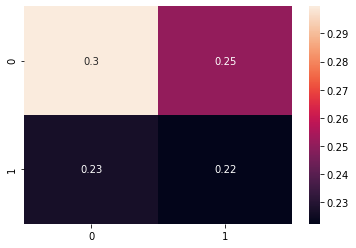

In [111]:
threshold = 0.4
y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype('int')

print(f'label {label}, threshold {threshold}')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [71]:
kf = KFold(n_splits=5)

params = {'objective':'binary:logistic',
          'max_depth': 6, # default 6
          'alpha': 10,
          'gamma' : 0, # default 0
          'subsample' : 1, # default 1
          'colsample_bytree' : 1, # default 1
          'min_child_weight' : 1, # default 1
          'learning_rate': 0.1,
          'alpha' : 0, # default 0
          'eval_metric' : 'auc',
          'n_estimators' : 10000,
          'verbosity' : 1,
          'seed' : 10
         }    

models = []
for fold, (train_index, valid_index) in enumerate(kf.split(data_train_valid)):
    X_train = data_train_valid.iloc[train_index][list_cols_training]
    y_train = data_train_valid.iloc[train_index][label]
    
    X_valid = data_train_valid.iloc[valid_index][list_cols_training]
    y_valid = data_train_valid.iloc[valid_index][label]
    
    print('*' * 50)
    print(f'training with fold {fold}')
    
    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_metric="auc",
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=200,
              verbose=100)
     
    models.append(model)

**************************************************
training with fold 0


/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-auc:0.58704	validation_1-auc:0.58300
[100]	validation_0-auc:0.77865	validation_1-auc:0.76530
[200]	validation_0-auc:0.79545	validation_1-auc:0.77812
[300]	validation_0-auc:0.80560	validation_1-auc:0.78429
[400]	validation_0-auc:0.81415	validation_1-auc:0.78802
[500]	validation_0-auc:0.82161	validation_1-auc:0.79041
[600]	validation_0-auc:0.82796	validation_1-auc:0.79151
[700]	validation_0-auc:0.83386	validation_1-auc:0.79280
[800]	validation_0-auc:0.84000	validation_1-auc:0.79352
[900]	validation_0-auc:0.84564	validation_1-auc:0.79420
[1000]	validation_0-auc:0.85090	validation_1-auc:0.79498
[1100]	validation_0-auc:0.85580	validation_1-auc:0.79575
[1200]	validation_0-auc:0.86062	validation_1-auc:0.79612
[1300]	validation_0-auc:0.86525	validation_1-auc:0.79673
[1400]	validation_0-auc:0.86950	validation_1-auc:0.79704
[1500]	validation_0-auc:0.87419	validation_1-auc:0.79752
[1600]	validation_0-auc:0.87876	validation_1-auc:0.79791


KeyboardInterrupt: 

In [52]:
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.44     41647
           1       0.54      0.60      0.57     48266

    accuracy                           0.52     89913
   macro avg       0.51      0.51      0.51     89913
weighted avg       0.51      0.52      0.51     89913



In [54]:
f1_score(y_test, y_pred)

0.5717630393294902

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

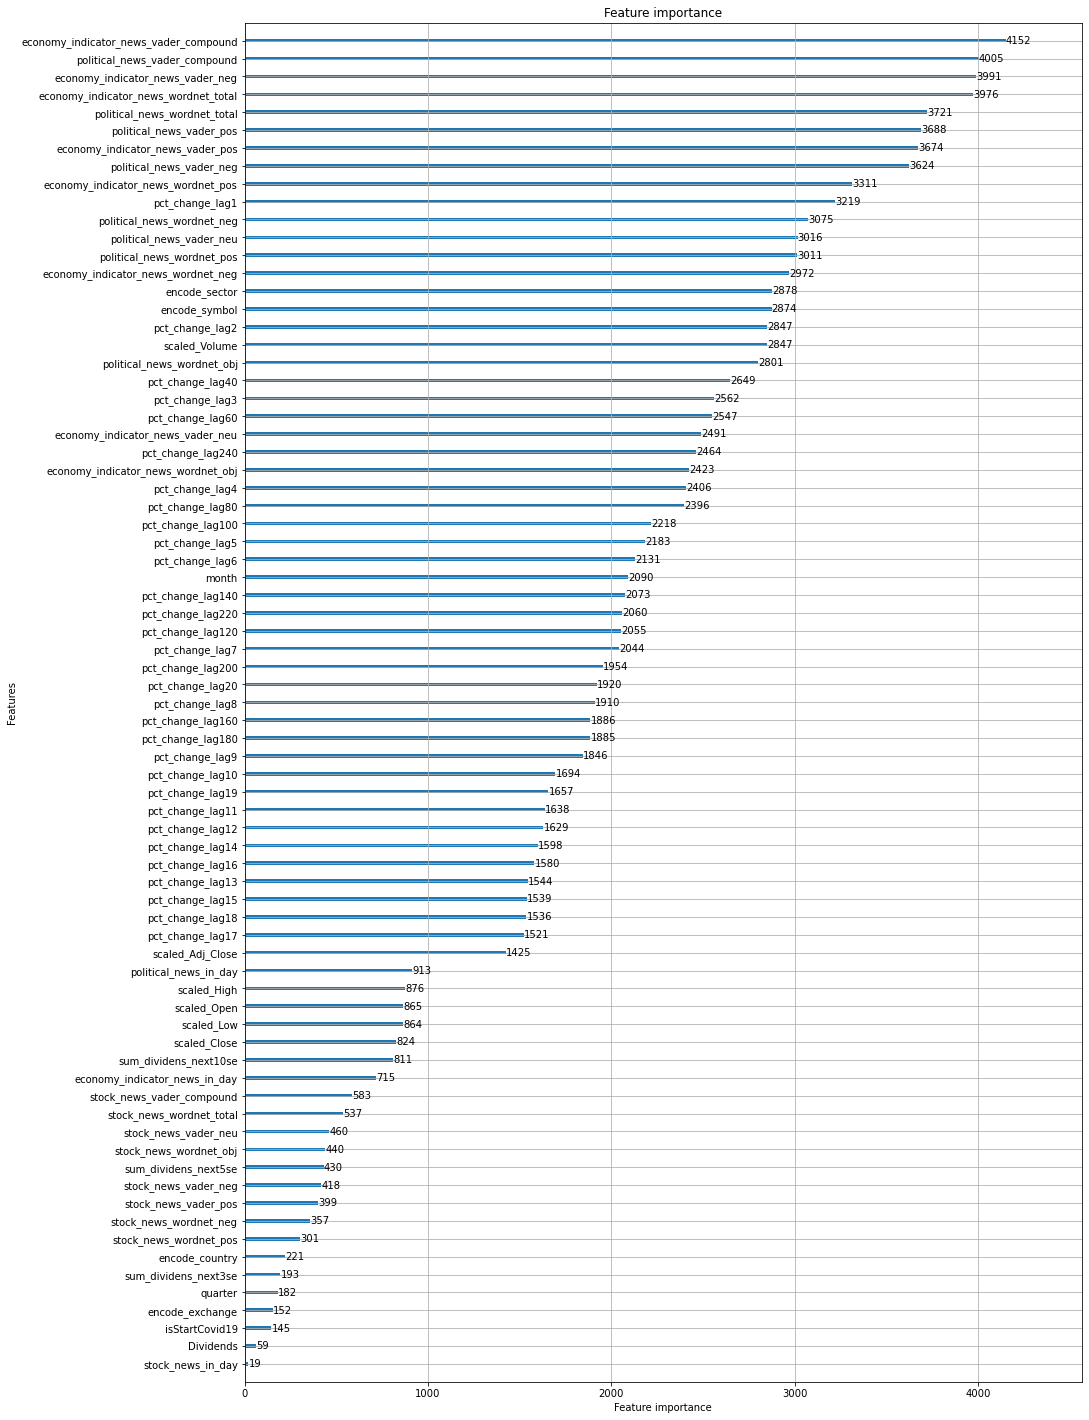

In [101]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

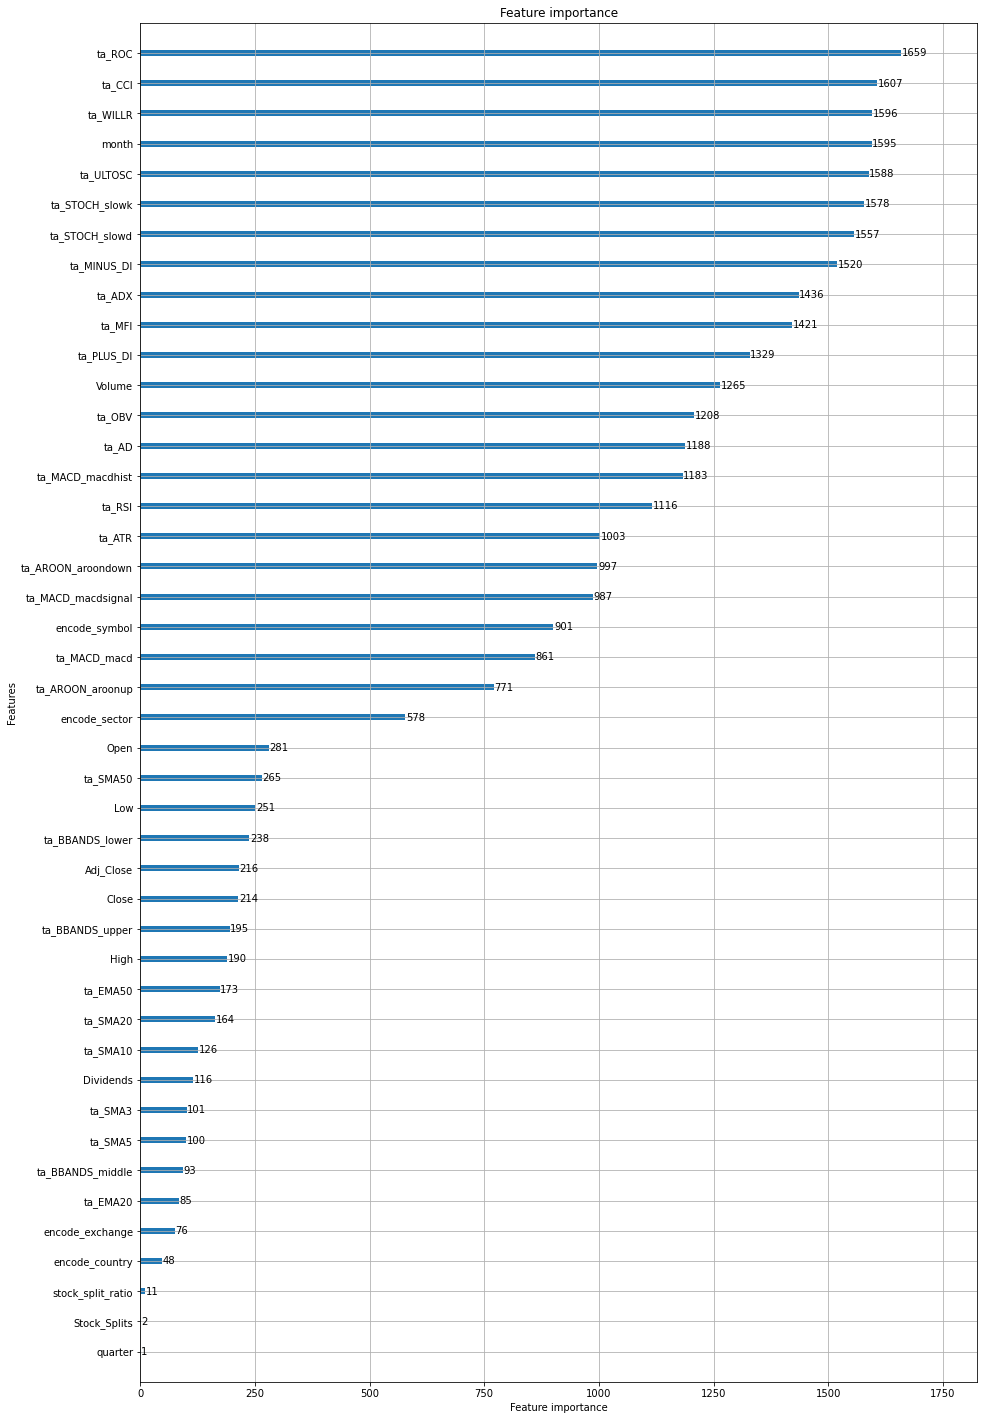

In [116]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_importance(model, ax=ax)

# XGBoost run cross valid to check impact

In [29]:
train_date_start = datetime.date(2010, 1, 1)

valid_date_end = datetime.date(2016, 6, 30)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

test_date_start = datetime.date(2021, 1, 1)
test_date_end = datetime.date(2021, 7, 31)

count = 0
predictions = []
while True:    
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))].copy()
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))].copy()
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))].copy()    
    
    list_training_cols = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols \
                         #+ political_news_cols #+ stock_news_cols #+ political_news_cols
    
    X_train = data_train[list_training_cols]
    y_train = data_train[label]
    
    X_valid = data_valid[list_training_cols]
    y_valid = data_valid[label]
    
    X_test = data_test[list_training_cols]
    y_test = data_test[label]
    
    tmp = data_test.copy()        
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.06,
              'subsample' : 0.14,
              'colsample_bytree' : 0.17, 
              'min_child_weight' : 9,
              'learning_rate': 0.04,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }        

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    predictions.append(y_pred_raw)
    
    # move to next period
    valid_date_start = valid_date_end + datetime.timedelta(days=1)
    valid_date_end = (valid_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    #check
    if valid_date_end >= test_date_start:
        break
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-12-31
valid_date_start 2016-01-01
valid_date_end   2016-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31
[0]	validation_0-logloss:0.68856	validation_1-logloss:0.68815
[20]	validation_0-logloss:0.63692	validation_1-logloss:0.63609


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.61899	validation_1-logloss:0.62279
[60]	validation_0-logloss:0.60857	validation_1-logloss:0.61782
[80]	validation_0-logloss:0.60111	validation_1-logloss:0.61442
[100]	validation_0-logloss:0.59421	validation_1-logloss:0.61396
[120]	validation_0-logloss:0.58829	validation_1-logloss:0.61327
[140]	validation_0-logloss:0.58160	validation_1-logloss:0.61375
[160]	validation_0-logloss:0.57655	validation_1-logloss:0.61454
[180]	validation_0-logloss:0.57207	validation_1-logloss:0.61422
[200]	validation_0-logloss:0.56714	validation_1-logloss:0.61480
[214]	validation_0-logloss:0.56346	validation_1-logloss:0.61502
**************************************************
mode 1
train_date_start 2010-01-01
train_date_end   2016-06-30
valid_date_start 2016-07-01
valid_date_end   2016-12-31
test_date_start  2021-01-01
test_date_end    2021-07-31
[0]	validation_0-logloss:0.68839	validation_1-logloss:0.69066
[20]	validation_0-logloss:0.63823	validation_1-logloss:0.66177


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[40]	validation_0-logloss:0.61990	validation_1-logloss:0.65247
[60]	validation_0-logloss:0.61049	validation_1-logloss:0.65054
[80]	validation_0-logloss:0.60314	validation_1-logloss:0.64951
[100]	validation_0-logloss:0.59702	validation_1-logloss:0.64882
[120]	validation_0-logloss:0.59183	validation_1-logloss:0.65067
[140]	validation_0-logloss:0.58574	validation_1-logloss:0.65289
[160]	validation_0-logloss:0.58058	validation_1-logloss:0.65465
[180]	validation_0-logloss:0.57583	validation_1-logloss:0.65378
[199]	validation_0-logloss:0.57166	validation_1-logloss:0.65291
**************************************************
mode 2
train_date_start 2010-01-01
train_date_end   2016-12-31
valid_date_start 2017-01-01
valid_date_end   2017-06-30
test_date_start  2021-01-01
test_date_end    2021-07-31
[0]	validation_0-logloss:0.68849	validation_1-logloss:0.68612
[20]	validation_0-logloss:0.63843	validation_1-logloss:0.62170
[40]	validation_0-logloss:0.62118	validation_1-logloss:0.60307
[60]	validati

**************************************************
model for vn stocks - with cross validation
threshold : 0.6
f1 score: 0.7796610169491526
accuracy score: 0.6661143330571665
              precision    recall  f1-score   support

           0       0.30      0.32      0.31       572
           1       0.79      0.77      0.78      1842

    accuracy                           0.67      2414
   macro avg       0.54      0.55      0.55      2414
weighted avg       0.67      0.67      0.67      2414



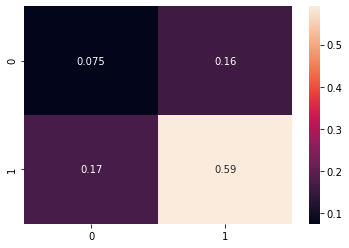

In [30]:
test_prediction = pd.DataFrame(np.array(predictions).T)

threshold = 0.6
y_pred = test_prediction.sum(axis=1) / len(test_prediction.columns)
y_pred = (y_pred >= threshold).astype(int)

print('*' * 50)
print('model for vn stocks - with cross validation')
print(f'threshold : {threshold}')
# print('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols')
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

# XGBoost run all sectors

In [25]:
df.head()

,symbol,Date,Open,High,Low,Close,Volume,sector,Close_next10_max,label_next10_max,ext_feat_OpenClose,ext_feat_upOrDownInDay,ext_feat_OpenHigh,ext_feat_OpenLow,ext_feat_CloseHigh,ext_feat_CloseLow,ext_feat_HighLow,ext_feat_countUpDays,pct_change_price_lag1,pct_change_price_lag2,pct_change_price_lag3,pct_change_price_lag4,pct_change_price_lag5,pct_change_price_lag6,pct_change_price_lag7,pct_change_price_lag8,pct_change_price_lag9,pct_change_price_lag10,pct_change_price_lag11,pct_change_price_lag12,pct_change_price_lag13,pct_change_price_lag14,pct_change_price_lag15,pct_change_price_lag20,pct_change_price_lag30,pct_change_price_lag40,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_ADX,ta_ATR,ta_ROC,month,quarter,encode_symbol,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_lm_pos,stock_news_lm_neg,stock_news_lm_polar,stock_news_lm_subject,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound
0,BID,2014-04-15,0.064275,0.064075,0.065975,0.064472,0.004805,Financial Services,12.0173,0,-0.005997,0,0.006029,-0.006021,0.012098,-0.000024,0.012123,19.0,-0.011969,-0.006021,-0.011969,-0.011969,-0.017855,-0.023663,-0.017855,-0.011969,-0.011969,-0.017855,-0.029411,-0.017855,-0.017855,-0.040691,-0.062496,-0.006021,-0.011969,-0.011969,0.069950,0.073274,0.068641,0.072093,0.062132,0.065872,0.066565,38.178623,25.083724,32.491953,19.392890,-0.505895,-0.042999,-0.951675,0.209150,-1.785515,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BID,2014-04-16,0.063854,0.063240,0.062930,0.062346,0.010653,Financial Services,12.0173,0,-0.030287,0,0.000000,-0.042426,0.031233,-0.012518,0.044306,18.0,-0.030310,-0.041917,-0.036149,-0.041917,-0.041917,-0.047624,-0.053257,-0.047624,-0.041917,-0.041917,-0.047624,-0.058830,-0.047624,-0.047624,-0.069768,-0.047624,-0.036149,-0.036149,0.069769,0.073007,0.068303,0.071930,0.063178,0.065431,0.064531,30.071387,23.398974,28.226255,21.266923,-0.512234,-0.046711,-0.808576,0.231553,-4.191703,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BID,2014-04-17,0.061749,0.062823,0.063800,0.062771,0.006812,Financial Services,11.8680,0,0.006272,1,0.025003,0.000000,0.018615,-0.006233,0.025003,19.0,0.006255,-0.024245,-0.035924,-0.030120,-0.035924,-0.035924,-0.041667,-0.047335,-0.041667,-0.035924,-0.035924,-0.041667,-0.052943,-0.041667,-0.041667,-0.074710,-0.030120,-0.030120,0.069476,0.072787,0.068040,0.071792,0.062802,0.064876,0.063810,33.131392,16.722486,21.735061,28.430218,-0.508181,-0.049475,-0.675698,0.236342,-3.592430,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BID,2014-04-18,0.062170,0.061988,0.063365,0.061921,0.007635,Financial Services,11.8680,0,-0.012399,0,0.006216,-0.012416,0.018849,-0.000017,0.018866,18.0,-0.012424,-0.006247,-0.036368,-0.047902,-0.042169,-0.047902,-0.047902,-0.053573,-0.059170,-0.053573,-0.047902,-0.047902,-0.053573,-0.064709,-0.053573,-0.101699,-0.042169,-0.059170,0.069071,0.072625,0.067717,0.071622,0.062441,0.064244,0.062916,30.279460,20.033941,20.051800,21.400122,-0.512724,-0.055683,-0.533868,0.235453,-5.357342,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BID,2014-04-21,0.061328,0.060737,0.061191,0.060221,0.005660,Financial Services,11.8680,1,-0.025144,0,0.000000,-0.031446,0.025792,-0.006465,0.032467,17.0,-0.025160,-0.037271,-0.031249,-0.060613,-0.071857,-0.066269,-0.071857,-0.071857,-0.077386,-0.082842,-0.077386,-0.071857,-0.071857,-0.077386,-0.088241,-0.114291,-0.066269,-0.071857,0.068620,0.072520,0.067254,0.071385,0.061812,0.063440,0.061964,25.543623,15.927101,17.561176,22.069679,-0.516091,-0.058446,-0.326074,0.245307,-8.284183,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df['sector'].unique()

array(['Financial Services', 'Technology', 'Energy', 'Basic Materials',
       'Real Estate', 'Consumer Staples', 'Consumer Discretionary'],
      dtype=object)

In [27]:
def write_log(log, text_write):
    print(log)
    text_write += log + '\n'
    return text_write

In [31]:
train_date_start = '2010-01-01'
valid_date_start = '2019-10-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

count = 0
threshold = 0.65
text_write = ''
for sector in df['sector'].unique():
    data_train = df[(df["Date"] >= train_date_start) & (df["Date"] < valid_date_start) & (df['sector']==sector)]
    data_valid = df[(df["Date"] >= valid_date_start) & (df["Date"] < test_date_start)  & (df['sector']==sector)]
    data_test = df[(df["Date"] >= test_date_start) & (df["Date"] <= test_date_end)  & (df['sector']==sector)]
    
    list_cols_train = train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols \
                         + political_news_cols  \
                         + stock_news_cols 
    
    X_train = data_train[list_cols_train]
    y_train = data_train[label]

    X_valid = data_valid[list_cols_train]
    y_valid = data_valid[label]

    X_test = data_test[list_cols_train]
    y_test = data_test[label]
    
    text_write = write_log('*' * 50, text_write)
    text_write = write_log(f'start mode with sector "{sector}"', text_write)
    text_write = write_log(f'start training date: "{train_date_start}"', text_write)
    text_write = write_log(f'start validation date: "{valid_date_start}"', text_write)
    text_write = write_log(f'start test date: "{test_date_start}"', text_write)
    text_write = write_log(f'end test date: "{test_date_end}"', text_write)
    text_write = write_log('list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols', text_write)
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.44,
              'subsample' : 0.73,
              'colsample_bytree' : 0.23, 
              'min_child_weight' : 6,
              'learning_rate': 0.03,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)

    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')

    text_write = write_log(f'threshold: {threshold}', text_write)
    text_write = write_log(f'f1 score: {f1_score(y_test, y_pred)}', text_write)
    text_write = write_log(f'accuracy score: {accuracy_score(y_test, y_pred)}', text_write)
    text_write = write_log(classification_report(y_test, y_pred), text_write)

    count += 1
    
with open('./exported_data/vn_ket qua tinh theo tung sector_20211011.txt', 'a') as f:
    f.write(text_write)

**************************************************
start mode with sector "Financial Services"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols
[0]	validation_0-logloss:0.68860	validation_1-logloss:0.68837
[20]	validation_0-logloss:0.62847	validation_1-logloss:0.62006


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-logloss:0.59902	validation_1-logloss:0.59634
[60]	validation_0-logloss:0.57818	validation_1-logloss:0.58674
[80]	validation_0-logloss:0.56464	validation_1-logloss:0.58588
[100]	validation_0-logloss:0.55404	validation_1-logloss:0.58700
[120]	validation_0-logloss:0.54431	validation_1-logloss:0.59009
[140]	validation_0-logloss:0.53665	validation_1-logloss:0.59254
[160]	validation_0-logloss:0.52809	validation_1-logloss:0.59564
[180]	validation_0-logloss:0.52113	validation_1-logloss:0.59699
[193]	validation_0-logloss:0.51557	validation_1-logloss:0.59859
threshold: 0.65
f1 score: 0.7238689547581905
accuracy score: 0.6049107142857143
              precision    recall  f1-score   support

           0       0.25      0.38      0.31       102
           1       0.79      0.67      0.72       346

    accuracy                           0.60       448
   macro avg       0.52      0.53      0.51       448
weighted avg       0.67      0.60      0.63       448

********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-logloss:0.44319	validation_1-logloss:0.56182
[120]	validation_0-logloss:0.42269	validation_1-logloss:0.57121
[140]	validation_0-logloss:0.40569	validation_1-logloss:0.57553
[160]	validation_0-logloss:0.39110	validation_1-logloss:0.58074
[169]	validation_0-logloss:0.38439	validation_1-logloss:0.58128
threshold: 0.65
f1 score: 0.8828828828828829
accuracy score: 0.796875
              precision    recall  f1-score   support

           0       0.25      0.22      0.24         9
           1       0.88      0.89      0.88        55

    accuracy                           0.80        64
   macro avg       0.56      0.56      0.56        64
weighted avg       0.79      0.80      0.79        64

**************************************************
start mode with sector "Energy"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[120]	validation_0-logloss:0.36188	validation_1-logloss:0.66411
[134]	validation_0-logloss:0.34859	validation_1-logloss:0.67183
threshold: 0.65
f1 score: 0.8316831683168318
accuracy score: 0.734375
              precision    recall  f1-score   support

           0       0.33      0.42      0.37        12
           1       0.86      0.81      0.83        52

    accuracy                           0.73        64
   macro avg       0.60      0.61      0.60        64
weighted avg       0.76      0.73      0.75        64

**************************************************
start mode with sector "Basic Materials"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_cols
[0]	validation_0-logloss:0.68512	validation_1-logloss:0.68775
[20]	validation_0-logloss:0.56953	validation_1-logloss:0.61279
[40]	va

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-logloss:0.41532	validation_1-logloss:0.62381
[120]	validation_0-logloss:0.39284	validation_1-logloss:0.65308
[140]	validation_0-logloss:0.37138	validation_1-logloss:0.66641
[160]	validation_0-logloss:0.35445	validation_1-logloss:0.68228
[162]	validation_0-logloss:0.35318	validation_1-logloss:0.68227
threshold: 0.65
f1 score: 0.2456140350877193
accuracy score: 0.328125
              precision    recall  f1-score   support

           0       0.25      0.93      0.39        15
           1       0.88      0.14      0.25        49

    accuracy                           0.33        64
   macro avg       0.56      0.54      0.32        64
weighted avg       0.73      0.33      0.28        64

**************************************************
start mode with sector "Real Estate"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[60]	validation_0-logloss:0.56092	validation_1-logloss:0.65123
[80]	validation_0-logloss:0.53991	validation_1-logloss:0.65233
[100]	validation_0-logloss:0.52243	validation_1-logloss:0.65466
[120]	validation_0-logloss:0.50434	validation_1-logloss:0.66142
[140]	validation_0-logloss:0.48722	validation_1-logloss:0.66847
[141]	validation_0-logloss:0.48666	validation_1-logloss:0.66790
threshold: 0.65
f1 score: 0.3246073298429319
accuracy score: 0.328125
              precision    recall  f1-score   support

           0       0.21      0.76      0.33        42
           1       0.76      0.21      0.32       150

    accuracy                           0.33       192
   macro avg       0.48      0.48      0.33       192
weighted avg       0.64      0.33      0.33       192

**************************************************
start mode with sector "Consumer Staples"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.51940	validation_1-logloss:0.66775
[100]	validation_0-logloss:0.50193	validation_1-logloss:0.67163
[120]	validation_0-logloss:0.48377	validation_1-logloss:0.67896
[140]	validation_0-logloss:0.46755	validation_1-logloss:0.68776
threshold: 0.65
f1 score: 0.13333333333333333
accuracy score: 0.2890625
              precision    recall  f1-score   support

           0       0.25      0.97      0.40        31
           1       0.88      0.07      0.13        97

    accuracy                           0.29       128
   macro avg       0.56      0.52      0.27       128
weighted avg       0.72      0.29      0.20       128

**************************************************
start mode with sector "Consumer Discretionary"
start training date: "2010-01-01"
start validation date: "2019-10-01"
start test date: "2021-05-01"
end test date: "2021-07-31"
list cols training: train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols + stock_news_cols + political_news_c

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.46634	validation_1-logloss:0.56533
[100]	validation_0-logloss:0.44233	validation_1-logloss:0.56599
[120]	validation_0-logloss:0.42135	validation_1-logloss:0.56725
[140]	validation_0-logloss:0.40483	validation_1-logloss:0.57016
[160]	validation_0-logloss:0.38705	validation_1-logloss:0.57753
[180]	validation_0-logloss:0.37131	validation_1-logloss:0.58113
[200]	validation_0-logloss:0.35629	validation_1-logloss:0.58342
[205]	validation_0-logloss:0.35391	validation_1-logloss:0.58374
threshold: 0.65
f1 score: 0.5930232558139535
accuracy score: 0.453125
              precision    recall  f1-score   support

           0       0.15      0.18      0.17        38
           1       0.62      0.57      0.59        90

    accuracy                           0.45       128
   macro avg       0.39      0.38      0.38       128
weighted avg       0.48      0.45      0.47       128



C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


# XGBoost cross validation

In [22]:
threshold = 0.6

train_date_start = datetime.date(2010, 1, 1)

test_date_start = datetime.date(2016, 1, 1)
test_date_end = (test_date_start + relativedelta.relativedelta(months=6)).replace(day=1) - datetime.timedelta(days=1)

valid_date_end = test_date_start - datetime.timedelta(days=1)
valid_date_start = (valid_date_end - relativedelta.relativedelta(months=5)).replace(day=1)

train_date_end = valid_date_start - datetime.timedelta(days=1)

count = 0
prediction = None
while True:    
    print('*' * 50)
    print('mode', count)
    print('train_date_start', train_date_start)
    print('train_date_end  ', train_date_end)
    
    print('valid_date_start', valid_date_start)
    print('valid_date_end  ', valid_date_end)
    
    print('test_date_start ', test_date_start)
    print('test_date_end   ', test_date_end)
    
    #filter data
    data_train = df[(df["Date"] >= train_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= train_date_end.strftime('%Y-%m-%d'))]
    data_valid = df[(df["Date"] >= valid_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= valid_date_end.strftime('%Y-%m-%d'))]
    data_test = df[(df["Date"] >= test_date_start.strftime('%Y-%m-%d')) & (df["Date"] <= test_date_end.strftime('%Y-%m-%d'))]
    
    X_train = data_train[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_train = data_train[[label]]
    
    X_valid = data_valid[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_valid = data_valid[[label]]
    
    X_test = data_test[train_cols +  ext_feature_cols + pct_change_lag_cols + ta_cols 
                         + stock_news_cols + political_news_cols]
    y_test = data_test[[label]]
    
    # model here
    params = {'objective':'binary:logistic',
              'max_depth': 6, # default 6
    #           'alpha': 10,
              'gamma' : 0.06,
              'subsample' : 0.14,
              'colsample_bytree' : 0.17, 
              'min_child_weight' : 9,
              'learning_rate': 0.04,
              'eval_metric' : 'logloss',
              'n_estimators' : 1000,
              'verbosity' : 0,
             }    

    model = XGBClassifier(**params) 
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              early_stopping_rounds=100,
              verbose=20)
    
    y_pred_raw = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_raw >= threshold).astype('int')
    
    print('threshold', threshold)
    print(f'f1 score: {f1_score(y_test, y_pred)}')
    print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))
    
    tmp = data_test.copy()
    tmp['prediction'] = y_pred_raw
    
    if prediction is None:
        prediction = tmp.copy()
    else:
        prediction = pd.concat([prediction, tmp], axis=0).reset_index(drop=True)
    
    #check
    if test_date_end >= df['Date'].max():
        break
    
    # move to next period
    test_date_start = test_date_end + datetime.timedelta(days=1)
    test_date_end = (test_date_end + relativedelta.relativedelta(months=7)).replace(day=1) - datetime.timedelta(days=1)
    
    if test_date_start >= datetime.date(2021, 1, 1):
        test_date_end += relativedelta.relativedelta(months=5)
    
    valid_date_end = test_date_start - datetime.timedelta(days=1)
    valid_date_start = (valid_date_end - relativedelta.relativedelta(months=3)).replace(day=1)

    train_date_end = valid_date_start - datetime.timedelta(days=1)
    
    count += 1

**************************************************
mode 0
train_date_start 2010-01-01
train_date_end   2015-06-30
valid_date_start 2015-07-01
valid_date_end   2015-12-31
test_date_start  2016-01-01
test_date_end    2016-06-30
[0]	validation_0-logloss:0.68830	validation_1-logloss:0.68975
[20]	validation_0-logloss:0.63562	validation_1-logloss:0.66439


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[40]	validation_0-logloss:0.61554	validation_1-logloss:0.65911
[60]	validation_0-logloss:0.60441	validation_1-logloss:0.66219
[80]	validation_0-logloss:0.59653	validation_1-logloss:0.66344
[100]	validation_0-logloss:0.58879	validation_1-logloss:0.66563
[120]	validation_0-logloss:0.58161	validation_1-logloss:0.66567
[138]	validation_0-logloss:0.57641	validation_1-logloss:0.66572
threshold 0.6
f1 score: 0.7134168157423972
accuracy score: 0.6105979581915411
              precision    recall  f1-score   support

           0       0.38      0.40      0.39       644
           1       0.72      0.71      0.71      1413

    accuracy                           0.61      2057
   macro avg       0.55      0.55      0.55      2057
weighted avg       0.62      0.61      0.61      2057

**************************************************
mode 1
train_date_start 2010-01-01
train_date_end   2016-02-29
valid_date_start 2016-03-01
valid_date_end   2016-06-30
test_date_start  2016-07-01
test_date_end   

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[40]	validation_0-logloss:0.61834	validation_1-logloss:0.62500
[60]	validation_0-logloss:0.60762	validation_1-logloss:0.61752
[80]	validation_0-logloss:0.59934	validation_1-logloss:0.61569
[100]	validation_0-logloss:0.59239	validation_1-logloss:0.61277
[120]	validation_0-logloss:0.58723	validation_1-logloss:0.61228
[140]	validation_0-logloss:0.58125	validation_1-logloss:0.61412
[160]	validation_0-logloss:0.57487	validation_1-logloss:0.61101
[180]	validation_0-logloss:0.57017	validation_1-logloss:0.61275
[200]	validation_0-logloss:0.56497	validation_1-logloss:0.61393
[220]	validation_0-logloss:0.56055	validation_1-logloss:0.61548
[240]	validation_0-logloss:0.55524	validation_1-logloss:0.61540
[259]	validation_0-logloss:0.55107	validation_1-logloss:0.61784
threshold 0.6
f1 score: 0.5972447325769854
accuracy score: 0.5502262443438914
              precision    recall  f1-score   support

           0       0.43      0.57      0.49       846
           1       0.67      0.54      0.60     

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[40]	validation_0-logloss:0.61823	validation_1-logloss:0.66289
[60]	validation_0-logloss:0.60820	validation_1-logloss:0.66054
[80]	validation_0-logloss:0.60057	validation_1-logloss:0.66119
[100]	validation_0-logloss:0.59439	validation_1-logloss:0.66139
[120]	validation_0-logloss:0.58858	validation_1-logloss:0.66099
[140]	validation_0-logloss:0.58305	validation_1-logloss:0.66450
[160]	validation_0-logloss:0.57864	validation_1-logloss:0.66492
[163]	validation_0-logloss:0.57769	validation_1-logloss:0.66565
threshold 0.6
f1 score: 0.7568081063964535
accuracy score: 0.6266407389402042
              precision    recall  f1-score   support

           0       0.21      0.19      0.20       501
           1       0.75      0.77      0.76      1556

    accuracy                           0.63      2057
   macro avg       0.48      0.48      0.48      2057
weighted avg       0.61      0.63      0.62      2057

**************************************************
mode 3
train_date_start 2010-01-01


C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[40]	validation_0-logloss:0.62111	validation_1-logloss:0.59262
[60]	validation_0-logloss:0.61048	validation_1-logloss:0.58202
[80]	validation_0-logloss:0.60312	validation_1-logloss:0.58093
[100]	validation_0-logloss:0.59679	validation_1-logloss:0.57887
[120]	validation_0-logloss:0.59082	validation_1-logloss:0.58134
[140]	validation_0-logloss:0.58592	validation_1-logloss:0.58205
[160]	validation_0-logloss:0.58113	validation_1-logloss:0.58335
[180]	validation_0-logloss:0.57615	validation_1-logloss:0.58595
[195]	validation_0-logloss:0.57222	validation_1-logloss:0.58674
threshold 0.6
f1 score: 0.6297085998578537
accuracy score: 0.5248518011855905
              precision    recall  f1-score   support

           0       0.26      0.50      0.34       534
           1       0.77      0.53      0.63      1659

    accuracy                           0.52      2193
   macro avg       0.51      0.52      0.48      2193
weighted avg       0.64      0.52      0.56      2193

**********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63586	validation_1-logloss:0.60536
[40]	validation_0-logloss:0.61814	validation_1-logloss:0.58102
[60]	validation_0-logloss:0.60858	validation_1-logloss:0.57493
[80]	validation_0-logloss:0.60127	validation_1-logloss:0.57314
[100]	validation_0-logloss:0.59596	validation_1-logloss:0.58104
[120]	validation_0-logloss:0.59061	validation_1-logloss:0.58514
[140]	validation_0-logloss:0.58573	validation_1-logloss:0.59046
[160]	validation_0-logloss:0.58142	validation_1-logloss:0.59449
[179]	validation_0-logloss:0.57680	validation_1-logloss:0.59808
threshold 0.6
f1 score: 0.7895065584009994
accuracy score: 0.666005946481665
              precision    recall  f1-score   support

           0       0.36      0.13      0.19       612
           1       0.70      0.90      0.79      1406

    accuracy                           0.67      2018
   macro avg       0.53      0.51      0.49      2018
weighted avg       0.60      0.67      0.61      2018

************************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63081	validation_1-logloss:0.64998
[40]	validation_0-logloss:0.61291	validation_1-logloss:0.65087
[60]	validation_0-logloss:0.60330	validation_1-logloss:0.65730
[80]	validation_0-logloss:0.59746	validation_1-logloss:0.66494
[100]	validation_0-logloss:0.59270	validation_1-logloss:0.67140
[120]	validation_0-logloss:0.58734	validation_1-logloss:0.67776
[123]	validation_0-logloss:0.58640	validation_1-logloss:0.67783
threshold 0.6
f1 score: 0.6596119929453262
accuracy score: 0.5597627737226277
              precision    recall  f1-score   support

           0       0.33      0.43      0.38       676
           1       0.71      0.62      0.66      1516

    accuracy                           0.56      2192
   macro avg       0.52      0.52      0.52      2192
weighted avg       0.59      0.56      0.57      2192

**************************************************
mode 6
train_date_start 2010-01-01
train_date_end   2018-08-31
valid_date_start 2018-09-01
valid_dat

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63096	validation_1-logloss:0.66207
[40]	validation_0-logloss:0.61295	validation_1-logloss:0.66194
[60]	validation_0-logloss:0.60522	validation_1-logloss:0.66363
[80]	validation_0-logloss:0.59826	validation_1-logloss:0.66769
[100]	validation_0-logloss:0.59250	validation_1-logloss:0.67007
[120]	validation_0-logloss:0.58751	validation_1-logloss:0.67256
[135]	validation_0-logloss:0.58455	validation_1-logloss:0.67263
threshold 0.6
f1 score: 0.7497453310696095
accuracy score: 0.6356895699456253
              precision    recall  f1-score   support

           0       0.36      0.30      0.33       600
           1       0.73      0.78      0.75      1423

    accuracy                           0.64      2023
   macro avg       0.54      0.54      0.54      2023
weighted avg       0.62      0.64      0.63      2023

**************************************************
mode 7
train_date_start 2010-01-01
train_date_end   2019-02-28
valid_date_start 2019-03-01
valid_dat

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.62977	validation_1-logloss:0.65584
[40]	validation_0-logloss:0.61149	validation_1-logloss:0.64944
[60]	validation_0-logloss:0.60296	validation_1-logloss:0.64881
[80]	validation_0-logloss:0.59733	validation_1-logloss:0.65240
[100]	validation_0-logloss:0.59210	validation_1-logloss:0.65208
[120]	validation_0-logloss:0.58710	validation_1-logloss:0.65448
[140]	validation_0-logloss:0.58233	validation_1-logloss:0.65538
[157]	validation_0-logloss:0.57920	validation_1-logloss:0.65526
threshold 0.6
f1 score: 0.6778711484593837
accuracy score: 0.5868881903906601
              precision    recall  f1-score   support

           0       0.44      0.41      0.42       820
           1       0.67      0.69      0.68      1407

    accuracy                           0.59      2227
   macro avg       0.55      0.55      0.55      2227
weighted avg       0.58      0.59      0.58      2227

**************************************************
mode 8
train_date_start 2010-01-01
t

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63225	validation_1-logloss:0.66614
[40]	validation_0-logloss:0.61482	validation_1-logloss:0.66231
[60]	validation_0-logloss:0.60599	validation_1-logloss:0.66102
[80]	validation_0-logloss:0.60049	validation_1-logloss:0.66116
[100]	validation_0-logloss:0.59527	validation_1-logloss:0.66119
[120]	validation_0-logloss:0.59080	validation_1-logloss:0.66030
[140]	validation_0-logloss:0.58617	validation_1-logloss:0.66036
[160]	validation_0-logloss:0.58191	validation_1-logloss:0.66102
[180]	validation_0-logloss:0.57881	validation_1-logloss:0.65808
[200]	validation_0-logloss:0.57583	validation_1-logloss:0.65826
[220]	validation_0-logloss:0.57213	validation_1-logloss:0.65826
[240]	validation_0-logloss:0.56847	validation_1-logloss:0.65770
[260]	validation_0-logloss:0.56547	validation_1-logloss:0.65825
[280]	validation_0-logloss:0.56261	validation_1-logloss:0.65816
[300]	validation_0-logloss:0.56011	validation_1-logloss:0.66014
[320]	validation_0-logloss:0.55701	validatio

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63309	validation_1-logloss:0.60664
[40]	validation_0-logloss:0.61680	validation_1-logloss:0.59042
[60]	validation_0-logloss:0.60801	validation_1-logloss:0.58697
[80]	validation_0-logloss:0.60250	validation_1-logloss:0.58724
[100]	validation_0-logloss:0.59833	validation_1-logloss:0.58750
[120]	validation_0-logloss:0.59385	validation_1-logloss:0.58796
[140]	validation_0-logloss:0.58950	validation_1-logloss:0.58897
[160]	validation_0-logloss:0.58561	validation_1-logloss:0.58834
[165]	validation_0-logloss:0.58471	validation_1-logloss:0.58968
threshold 0.6
f1 score: 0.8286722780342113
accuracy score: 0.7165318957771788
              precision    recall  f1-score   support

           0       0.18      0.18      0.18       375
           1       0.83      0.82      0.83      1851

    accuracy                           0.72      2226
   macro avg       0.50      0.50      0.50      2226
weighted avg       0.72      0.72      0.72      2226

***********************

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\anaconda3\envs\jupyterNotebook\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20]	validation_0-logloss:0.63178	validation_1-logloss:0.57461
[40]	validation_0-logloss:0.61455	validation_1-logloss:0.53573
[60]	validation_0-logloss:0.60673	validation_1-logloss:0.51908
[80]	validation_0-logloss:0.60045	validation_1-logloss:0.51421
[100]	validation_0-logloss:0.59594	validation_1-logloss:0.51372
[120]	validation_0-logloss:0.59179	validation_1-logloss:0.51443
[140]	validation_0-logloss:0.58783	validation_1-logloss:0.52011
[160]	validation_0-logloss:0.58320	validation_1-logloss:0.52269
[180]	validation_0-logloss:0.57967	validation_1-logloss:0.52146
[198]	validation_0-logloss:0.57687	validation_1-logloss:0.52586
threshold 0.6
f1 score: 0.8007918831972284
accuracy score: 0.6884674922600619
              precision    recall  f1-score   support

           0       0.32      0.26      0.29       624
           1       0.78      0.83      0.80      1960

    accuracy                           0.69      2584
   macro avg       0.55      0.54      0.54      2584
weighted avg  

C:\anaconda3\envs\jupyterNotebook\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


threshold 0.6
f1 score: 0.7114337568058076
accuracy score: 0.5998825651134505
              precision    recall  f1-score   support

           0       0.33      0.37      0.35      6889
           1       0.73      0.69      0.71     16954

    accuracy                           0.60     23843
   macro avg       0.53      0.53      0.53     23843
weighted avg       0.61      0.60      0.61     23843



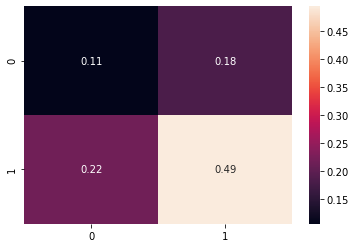

In [24]:
threshold = 0.6
y_pred = (prediction['prediction'] >= threshold).astype('int')
y_test = prediction[label]
print('threshold', threshold)
print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='all')
f = sns.heatmap(cm, annot=True)

In [27]:
list_cols = [
    'Date', 'symbol',
    'Open', 'High', 'Low', 'Close', 'Volume',
    'label_next10_max', 'prediction'
]

prediction[list_cols].to_csv('./exported_data/vn_prediction_crossValidation_20211007.csv', index=False)

In [25]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [26]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# X_train_val = data_train_valid[train_cols + ta_cols]
# y_train_val = data_train_valid[label]

In [27]:
X_train_ = np.expand_dims(X_train, 1)
y_train_ = y_train.values

In [28]:
X_valid_ = np.expand_dims(X_valid, 1)
y_valid_ = y_valid.values

In [30]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50)

Epoch 1/50
1184/1184 [==============================] - 4s 3ms/step - loss: 0.6776 - accuracy: 0.6113 - val_loss: 0.6694 - val_accuracy: 0.6063
Epoch 2/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6596 - accuracy: 0.6269 - val_loss: 0.6715 - val_accuracy: 0.6063
Epoch 3/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6611 - accuracy: 0.6221 - val_loss: 0.6684 - val_accuracy: 0.6063
Epoch 4/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6587 - accuracy: 0.6247 - val_loss: 0.6703 - val_accuracy: 0.6063
Epoch 5/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6600 - accuracy: 0.6216 - val_loss: 0.6689 - val_accuracy: 0.6063
Epoch 6/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6593 - accuracy: 0.6231 - val_loss: 0.6726 - val_accuracy: 0.6063
Epoch 7/50
1184/1184 [==============================] - 3s 3ms/step - loss: 0.6577 - accuracy: 0.6225 - val_loss: 0.6700 - val_accuracy:

In [109]:
threshold = 0.5
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f'f1 score: {f1_score(y_test, y_pred)}')
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

f1 score: 0.0
accuracy score: 0.6515519223400179
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     20404
           1       0.00      0.00      0.00     10912

    accuracy                           0.65     31316
   macro avg       0.33      0.50      0.39     31316
weighted avg       0.42      0.65      0.51     31316



/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tuongnguyen/anaconda3/envs/jupyterNotebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

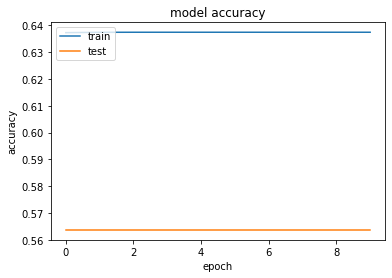

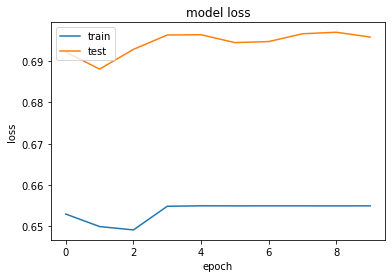

In [112]:
# summarize history for accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(CuDNNLSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='tanh'))

opt = tf.keras.optimizers.RMSprop(lr=7e-3)
model.compile(loss='mse',optimizer=opt, metrics=['mse'])
return model

In [26]:
X_train = np.expand_dims(X_train, 1)
y_train = y_train.values

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=256, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# # model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(1024, activation="relu"))
# model.add(tf.keras.layers.Dense(512, activation="relu"))
# model.add(tf.keras.layers.Dense(256, activation="relu"))
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(10, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001#, rho=0.9, momentum=0.0, epsilon=1e-07,
)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

with tf.device('/GPU:0'):
    history_model = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=4)

Epoch 1/10


In [46]:
sector

'Technology'

In [54]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,pct_change_next1,pct_change_next3,label_t3,country,industry,sector,exchange,market,pct_change_lag1,pct_change_lag2,pct_change_lag3,pct_change_lag4,pct_change_lag5,pct_change_lag6,pct_change_lag7,pct_change_lag8,pct_change_lag9,pct_change_lag10,pct_change_lag11,pct_change_lag12,pct_change_lag13,pct_change_lag14,pct_change_lag15,pct_change_lag16,pct_change_lag17,pct_change_lag18,pct_change_lag19,pct_change_lag20,pct_change_lag21,pct_change_lag22,pct_change_lag23,pct_change_lag24,pct_change_lag25,pct_change_lag26,pct_change_lag27,pct_change_lag28,pct_change_lag29,pct_change_lag30,ext_features_close_pct_change_01,ext_features_close_pct_change_12,ext_features_close_pct_change_23,ext_features_close_pct_change_34,ext_features_close_pct_change_45,ext_features_high_open_00,ext_features_high_open_01,ext_features_high_open_02,ext_features_high_open_03,ext_features_high_open_04,ext_features_high_open_05,ext_features_high_open_11,ext_features_high_open_22,ext_features_high_open_33,ext_features_high_open_44,ext_features_high_open_55,ext_features_low_open_00,ext_features_low_open_11,ext_features_low_open_22,ext_features_low_open_33,ext_features_low_open_44,ext_features_low_open_55,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,month,quarter,scaled_Open,scaled_High,scaled_Low,scaled_Close,scaled_Adj Close,scaled_Volume,encode_sector,encode_country,encode_exchange,isStartCovid19,stock_news_in_day,stock_news_vader_neg,stock_news_vader_pos,stock_news_vader_neu,stock_news_vader_compound,stock_news_wordnet_pos,stock_news_wordnet_neg,stock_news_wordnet_obj,stock_news_wordnet_total,political_news_in_day,political_news_vader_neg,political_news_vader_pos,political_news_vader_neu,political_news_vader_compound,political_news_wordnet_pos,political_news_wordnet_neg,political_news_wordnet_obj,political_news_wordnet_total,economy_indicator_news_in_day,economy_indicator_news_vader_neg,economy_indicator_news_vader_pos,economy_indicator_news_vader_neu,economy_indicator_news_vader_compound,economy_indicator_news_wordnet_pos,economy_indicator_news_wordnet_neg,economy_indicator_news_wordnet_obj,economy_indicator_news_wordnet_total,stock_market_news_in_day,stock_market_news_vader_neg,stock_market_news_vader_pos,stock_market_news_vader_neu,stock_market_news_vader_compound,stock_market_news_wordnet_pos,stock_market_news_wordnet_neg,stock_market_news_wordnet_obj,stock_market_news_wordnet_total
7254,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.610315,302220800,AAPL,0.005374,0.027162,1,United States,Consumer Electronics,Technology,NASDAQ,us_market,0.015383,0.015082,0.021334,0.011561,0.019587,0.031815,0.037281,0.038591,0.075927,0.079287,0.085211,0.081643,0.057663,0.049484,0.044739,0.052655,0.056902,0.051874,0.046360,0.055248,0.060062,0.075955,0.101902,0.093348,0.131089,0.120548,0.092215,0.114414,0.096789,0.089611,0.015266,-0.000296,0.006140,-0.009615,0.007903,0.007544,0.022035,0.022308,0.013693,0.023052,0.031547,0.006841,0.005562,0.003337,0.014750,0.009710,-0.000978,-0.000050,-0.007190,-0.013734,-0.000199,-0.000501,0.002229,0.002228,0.002204,0.002223,0.002258,0.002206,0.002220,0.002176,0.002226,0.002238,-0.077995,-0.100807,0.051705,66.163947,72.080579,69.473305,63.463640,18.630647,16.340550,16.590612,35.509983,18.612016,-3.647316,0.918084,0.000768,62.404084,7.928729,14.285714,100.000000,1,1,0.002617,0.002630,0.002663,0.002633,0.002242,0.200662,9,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000
7255,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.678085,260022000,AAPL,0.011102,0.020051,1,

In [55]:
# data = df[df['sector'] == sector].copy().reset_index()
# data_train = data[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

In [124]:
sector = 'Technology'
data_pca = df[df['sector']==sector].copy().reset_index(drop=True)
data_train_pca = data_pca[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

In [ ]:

plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=vectorizer(y))

In [ ]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

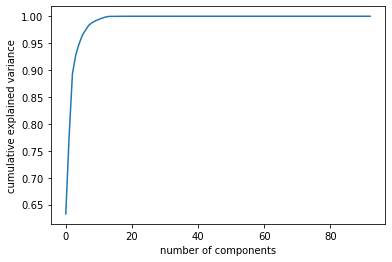

In [125]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [126]:
n_components = 10
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(data_train_pca)
print(f"Our reduced dimensions can explain {sum(pca.explained_variance_ratio_):.4f} % of the variance in the original data")

Our reduced dimensions can explain 0.9917 % of the variance in the original data


In [127]:
reducedDf = pd.DataFrame(data=principalComponents, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_pca['Date']
reducedDf['label_t3'] = data_pca['label_t3']
reducedDf.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-70.069784,3.749357,10.551597,-8.558242,-9.189304,-0.182206,-3.549381,-1.433659,0.030037,6.969359,2012-01-03,1
1,-78.891352,2.945219,5.337127,-6.165287,-3.686621,-3.314520,0.872366,-3.778433,1.939582,6.803152,2012-01-04,1
2,-93.493571,-4.953141,-0.557756,0.223312,3.611930,-6.892062,5.220530,-5.516167,3.665578,6.043418,2012-01-05,1
3,-100.003825,-9.987616,-1.092873,2.818413,11.203141,-9.525833,3.179822,-2.640966,5.327742,7.222354,2012-01-06,0
4,-92.775555,-3.078302,-0.142123,10.751203,16.950225,-9.317709,-1.096142,-0.927851,2.402696,7.612020,2012-01-09,0


In [ ]:
%%time
# sector = 'Technology'
n_components = 20

# data_tsne = df[df['sector']==sector].copy().reset_index(drop=True)
data_train_tnse = df[train_cols + pct_change_lag_cols + ext_feature_cols + ta_cols]

tsne = TSNE(n_components=n_components, perplexity=50, method='exact')
data_reduced_tsne = tsne.fit_transform(data_train_tnse)

reducedDf = pd.DataFrame(data=data_reduced_tsne, columns=[f'd{i}' for i in range(0, n_components)])
reducedDf['Date'] = data_tsne['Date']
reducedDf['symbol'] = data_tsne['symbol']
reducedDf['label'] = data_tsne['label_t3']

In [128]:
train_date_start = '2010-01-01'
valid_date_start = '2020-06-01'
test_date_start = '2021-05-01'
test_date_end = '2021-07-31'

data_train = reducedDf[(reducedDf["Date"] >= train_date_start) & (reducedDf["Date"] < valid_date_start)]
data_valid = reducedDf[(reducedDf["Date"] >= valid_date_start) & (reducedDf["Date"] < test_date_start)]
data_test = reducedDf[(reducedDf["Date"] >= test_date_start) & (reducedDf["Date"] <= test_date_end)]

data_train = shuffle(data_train).reset_index(drop=True)

In [129]:
print('train shape', data_train.shape)
print('valid shape', data_valid.shape)
# print('train valid shape', data_train_valid.shape)
print('test shape', data_test.shape)

print(f'valid ratio {data_valid.shape[0] / (data_valid.shape[0] + data_train.shape[0])}')

train shape (144442, 12)
valid shape (16472, 12)
test shape (4473, 12)
valid ratio 0.10236523857464236


In [130]:
data_train.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,Date,label_t3
0,-46.055482,-26.309333,38.033506,3.976109,-6.616631,5.658540,6.479843,5.153382,-8.199018,2.640555,2019-06-25,1
1,-29.170939,25.468216,-2.823779,-30.592676,3.615985,-19.840973,7.042529,5.969284,-4.565430,-6.112230,2019-11-26,0
2,14.213304,42.096868,-0.599361,-8.958077,-0.210669,12.354283,-11.985723,-3.055317,-1.944377,-9.094315,2013-01-30,0
3,-24.655848,-23.515131,53.043560,-16.075260,-8.350646,7.923957,6.810792,-11.847214,-3.568611,-6.889425,2013-12-10,0
4,26.445225,-66.468305,-17.746687,-30.547832,8.182007,-0.675666,10.049485,5.526222,-0.097277,-2.083100,2016-01-22,0


In [131]:
X_train = data_train.drop(['Date', 'label_t3'], axis=1)
y_train = data_train['label_t3']

X_valid = data_valid.drop(['Date', 'label_t3'], axis=1)
y_valid = data_valid['label_t3']

X_test = data_test.drop(['Date', 'label_t3'], axis=1)
y_test = data_test['label_t3']

In [132]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

params = {
    "objective": "binary", # ,"regression"
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_leaves": 50,
#     "max_bin": 32,
#     "feature_fraction": 0.6,
#     "bagging_fraction" : 0.6,
#     "bagging_freq" : 0,
#     "max_depth" : 20,
#     "verbosity": 100,
#     "drop_rate": 0.1,
#     "is_unbalance": False,
#     "max_drop": 50,
#     "min_child_samples": 10,
#     "min_child_weight": 150,
#     "lambda_l1" : 10.,
#     "lambda_l2" : 10.,
#     "min_split_gain": 0,
    "num_threads" : -1,
    "metric" : "binary_logloss"
    # "metric" : "rmse"
}

model = lgb.train(params=params, 
                  train_set=dtrain, 
                  num_boost_round=10000, 
                  valid_sets=[dtrain, dvalid], 
                  verbose_eval=20,
                  early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 54608, number of negative: 89834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 144442, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378062 -> initscore=-0.497783
[LightGBM] [Info] Start training from score -0.497783
Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.661457	valid_1's binary_logloss: 0.689459
[40]	training's binary_logloss: 0.660212	valid_1's binary_logloss: 0.688749
[60]	training's binary_logloss: 0.659222	valid_1's binary_logloss: 0.688234
[80]	training's binary_logloss: 0.658387	valid_1's binary_logloss: 0.687805
[100]	training's binary_logloss: 0.657677	valid_1's binary_logloss: 0.687538
[120]	training's binary_logloss: 0.65706	valid_1's binary_l

In [140]:
threshold = 0.4
y_valid_pred = (model.predict(X_valid) >= threshold).astype('int')

print(f1_score(y_valid_pred, y_valid))
print(classification_report(y_valid, y_valid_pred))

0.3708562931863903
              precision    recall  f1-score   support

           0       0.59      0.77      0.67      9335
           1       0.49      0.30      0.37      7137

    accuracy                           0.56     16472
   macro avg       0.54      0.53      0.52     16472
weighted avg       0.55      0.56      0.54     16472



In [139]:
threshold = 0.4
y_pred = (model.predict(X_test) >= threshold).astype('int')

print(f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

0.3549295774647887
              precision    recall  f1-score   support

           0       0.60      0.69      0.64      2658
           1       0.41      0.31      0.35      1815

    accuracy                           0.54      4473
   macro avg       0.50      0.50      0.50      4473
weighted avg       0.52      0.54      0.53      4473



In [ ]:
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True)

In [135]:
df[(df['sector']=='Technology') & (df['Date']>='2021-01-01')].groupby('label_t3').size()

label_t3
0    6402
1    4461
dtype: int64

In [136]:
data_test.groupby('label_t3').size()

label_t3
0    2658
1    1815
dtype: int64

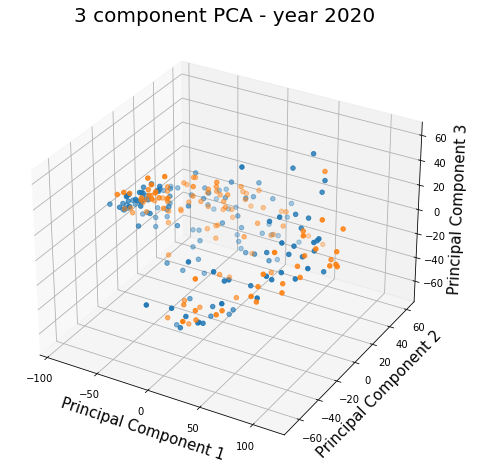

In [74]:
year = 2020
symbol = 'MSFT'

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title(f'3 component PCA - year {year}', fontsize = 20)

getdata = principalDf[(principalDf['Date'].dt.year==year) & (principalDf['symbol']==symbol)]

ax.scatter3D(getdata[(getdata['label']==0)]['d1'],
             getdata[(getdata['label']==0)]['d2'],
             getdata[(getdata['label']==0)]['d3'],)

ax.scatter3D(getdata[(getdata['label']==1)]['d1'],
             getdata[(getdata['label']==1)]['d2'],
             getdata[(getdata['label']==1)]['d3'],)
# ax.legend(targets)
ax.grid()

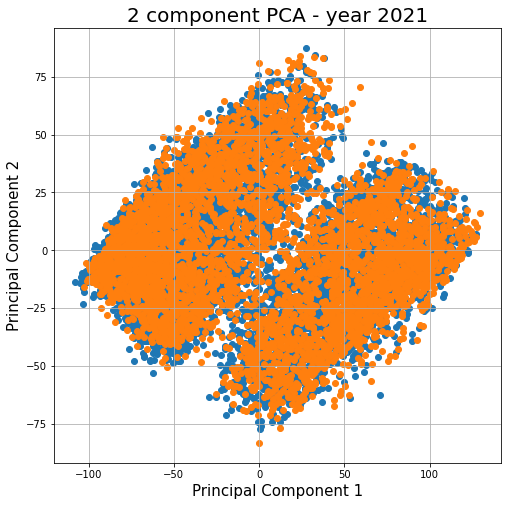

In [64]:
year = 2021
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'2 component PCA - year {year}', fontsize = 20)

ax.scatter(principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==0) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)

ax.scatter(principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 1'],
           principalDf[(principalDf['label']==1) & (principalDf['Date'].dt.year==year)]['Dimension 2'],)
# ax.legend(targets)
ax.grid()

In [63]:
s = pd.Series([1, 2, 3, 4, 5])
s

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [114]:
s.rolling(3).sum().shift(-3)

0     9.0
1    12.0
2     NaN
3     NaN
4     NaN
dtype: float64

In [67]:
s.rolling(3).apply(np.prod)

0     NaN
1     NaN
2     6.0
3    24.0
4    60.0
dtype: float64

In [47]:
help(talib.SMA)

Help on function SMA in module talib._ta_lib:

SMA(...)
    SMA(real[, timeperiod=?])
    
    Simple Moving Average (Overlap Studies)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 30
    Outputs:
        real



In [14]:
import matplotlib.pyplot as plt

In [47]:
close = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Adj Close']
high = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['High']
low = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['Low']
# ta_SMA10 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA10']
# ta_SMA20 = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_SMA20']

# upper = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_upper']
# lower = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_BBANDS_lower']

# macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
ta_STOCH_slowk = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowk']
ta_STOCH_slowd = df[(df['symbol']=='AAPL')&(df['Date']>='2021-01-01')]['ta_STOCH_slowd']


slowk, slowd = talib.STOCH(high, low, close)

In [2]:
import ta

In [49]:
slowd - ta_STOCH_slowd

10100             NaN
10101             NaN
10102             NaN
10103             NaN
10104             NaN
10105             NaN
10106             NaN
10107             NaN
10108   -3.836931e-13
10109   -3.907985e-13
10110   -3.872458e-13
10111   -3.907985e-13
10112   -3.836931e-13
10113   -3.907985e-13
10114   -3.836931e-13
10115   -3.836931e-13
10116   -3.836931e-13
10117   -3.694822e-13
10118   -3.836931e-13
10119   -3.765876e-13
10120   -3.765876e-13
10121   -3.801404e-13
10122   -3.836931e-13
10123   -3.765876e-13
10124   -3.694822e-13
10125   -3.694822e-13
10126   -3.836931e-13
10127   -3.765876e-13
10128   -3.765876e-13
10129   -3.801404e-13
10130   -3.765876e-13
10131   -3.765876e-13
10132   -3.765876e-13
10133   -3.801404e-13
10134   -3.801404e-13
10135   -3.801404e-13
10136   -3.836931e-13
10137   -3.765876e-13
10138   -3.765876e-13
10139   -3.765876e-13
10140   -3.765876e-13
10141   -3.765876e-13
10142   -3.765876e-13
10143   -3.801404e-13
10144   -3.801404e-13
10145   -3

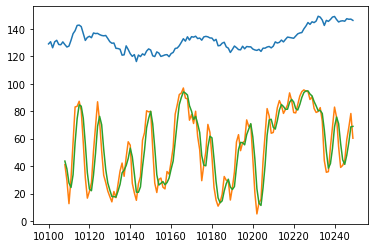

In [51]:
plt.plot(close, label='Closing Prices')
# plt.plot(rsi.values, label='rsi')
plt.plot(slowk, label='slowk')
plt.plot(slowd, label='slowd')
plt.show()

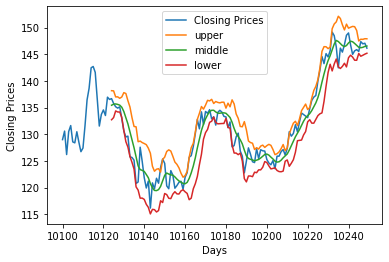

In [32]:
import matplotlib.pyplot as plt
# Plot the data
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(close, label='Closing Prices')
plt.plot(upper, label='upper')
plt.plot(middle, label='middle')
plt.plot(lower, label='lower')
plt.legend()
plt.show()

In [3]:
tmp = pd.DataFrame(np.random.random(100))

tmp['SMA'] = talib.SMA(tmp[0], timeperiod=10)
tmp['SMA2'] = ta.trend.sma_indicator(tmp[0], window=10)

tmp['delta'] = tmp['SMA']-tmp['SMA2']
tmp

,0,SMA,SMA2,delta
0,0.535400,NaN,NaN,NaN
1,0.277686,NaN,NaN,NaN
2,0.998812,NaN,NaN,NaN
3,0.025393,NaN,NaN,NaN
4,0.230199,NaN,NaN,NaN
5,0.400834,NaN,NaN,NaN
6,0.584140,NaN,NaN,NaN
7,0.280612,NaN,NaN,NaN
8,0.100513,NaN,NaN,NaN
9,0.368433,0.380202,0.380202,0.000000e+00


In [64]:
df

,Date,symbol,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,sector,country,exchange,ta_SMA3,ta_SMA5,ta_SMA10,ta_SMA20,ta_SMA50,ta_EMA20,ta_EMA50,ta_BBANDS_upper,ta_BBANDS_middle,ta_BBANDS_lower,ta_MACD_macd,ta_MACD_macdsignal,ta_MACD_macdhist,ta_RSI,ta_STOCH_slowk,ta_STOCH_slowd,ta_MFI,ta_OBV,ta_AD,ta_MINUS_DI,ta_PLUS_DI,ta_ADX,ta_WILLR,ta_CCI,ta_ATR,ta_ULTOSC,ta_ROC,ta_AROON_aroondown,ta_AROON_aroonup,adj_close_lead,adjust_close_diff,label,stock_split_ratio,sum_dividens_next10se,sum_dividens_next5se,sum_dividens_next3se,ratio_stock_split_next10se,ratio_stock_split_next5se,ratio_stock_split_next3se,month,quarter,encode_symbol,encode_sector,encode_country,encode_exchange
3852,2015-03-16,A,41.160000,41.830002,41.110001,41.810001,39.410793,2551400.0,0.00,0.0,Healthcare,United States,NYSE,38.892348,38.696286,39.119521,39.280237,37.899021,38.903246,37.899021,39.495359,38.727775,37.960190,0.278070,0.423520,-0.145451,55.404715,52.373018,30.688019,47.488445,3965900.0,4.637804e+06,21.313331,22.283099,22.905749,-41.891883,-21.774436,0.700175,45.636802,-2.084317,92.857143,28.571429,39.193985,-0.216808,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3853,2015-03-17,A,41.520000,41.689999,41.060001,41.580002,39.193985,1504900.0,0.00,0.0,Healthcare,United States,NYSE,39.043168,38.875381,39.055422,39.330196,37.918250,38.930935,37.949804,39.508498,38.778795,38.049092,0.270770,0.392970,-0.122200,53.372139,68.312218,48.262883,40.042034,2461000.0,5.617197e+06,20.190756,20.575251,21.336993,-52.252217,-34.309733,0.703734,51.868161,-1.609107,85.714286,21.428571,39.702999,0.509014,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3854,2015-03-18,A,41.450001,42.380001,41.169998,42.119999,39.702999,1295600.0,0.00,0.0,Healthcare,United States,NYSE,39.435926,39.114806,39.066733,39.357532,37.961987,39.004465,38.018557,39.789289,38.927950,38.066610,0.302571,0.374890,-0.072320,57.330007,88.470232,69.718489,45.379175,3756600.0,6.356007e+06,17.818052,24.858604,20.991310,-27.928036,33.684487,0.739896,55.132998,0.285713,78.571429,14.285714,39.787838,0.084839,1,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3855,2015-03-19,A,42.049999,42.250000,41.820000,42.209999,39.787838,1085700.0,0.00,0.0,Healthcare,United States,NYSE,39.561607,39.324068,39.065791,39.407491,38.019110,39.079072,38.087940,40.036899,39.132660,38.228421,0.330805,0.366073,-0.035268,57.970363,85.932519,80.904989,50.754213,4842300.0,7.239711e+06,17.051198,23.788738,20.670319,-23.873978,65.886919,0.717761,64.347453,-0.023676,71.428571,7.142857,39.787838,-0.000000,0,1.0,0.1,0.0,0.0,1.0,1.0,1.0,3,1,0,6,5,1
3856,2015-03-20,A,42.389999,42.529999,42.200001,42.209999,39.787838,2315500.0,0.00,0.0,Healthcare,United States,NYSE,39.759558,39.576691,39.129890,39.419745,38.066430,39.146574,38.154603,39.814506,39.341976,38.869446,0.349156,0.362690,-0.013533,57.970363,85.037594,86.480115,51.633493,4842300.0,5.064522e+06,16.465524,25.886019,20.782694,-17.561012,105.925682,0.690063,62.178001,1.637392,64.285714,0.000000,39.778408,-0.009430,0,1.0,0.1,0.1,0.0,1.0,1.0,1.0,3,1,0,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,2021-07-20,ZTS,197.240005,201.449997,197.240005,200.110001,200.110001,1884900.0,0.25,0.0,Healthcare,United States,NYSE,199.039215,199.626047,198.637976,193.339521,183.099781,193.926732,185.200231,202.546419,200.257493,197.968568,5.046538,5.037831,0.008707,72.130848,51.201952,57.261579,66.887439,278147700.0,1.933108e+08,12.645525,30.793608,46.941946,-11.725356,68.413181,2.985932,65.801650,3.269357,7.142857,71.428571,198.039993,-2.070007,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,7,3,496,6,5,1
2131,2021-07-21,ZTS,200.869995,200.869995,197.110001,198.039993,198.039993,1877600.0,0.00,0.0,Healthcare,United States,NYSE,198.576665,199.028918,198.726923,193.922313,183.641507,194.318471,185.703751,202.091330,200.027763,197.964197,4.

In [1]:
1

1